## TO trash

In [109]:
# PREPROCESSING
from imblearn.over_sampling import KMeansSMOTE
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
# CLASSIFIERS
from sklearn.svm import SVC
from  sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron, LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis,  LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from xgboost import XGBClassifier
# PERFORMANCES & METRICS
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, classification_report, f1_score, roc_curve, auc, balanced_accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedKFold, cross_val_score, cross_val_predict, RepeatedStratifiedKFold
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.inspection import permutation_importance
from statsmodels.stats.outliers_influence import variance_inflation_factor
# OTHERS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from collections import defaultdict


#### CLASSIFIERS BEST FIT ##############################################################################################################

def fit_qda_model(X_train,X_test, y_train, score):
    # Scale the features (may be useful if we are going to add other features with different scales)
    scaler = StandardScaler()
    #X = scaler.fit_transform(X.astype(np.float64))
    X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
    X_test_scaled = scaler.fit_transform(X_test.astype(np.float64))
    # Create a QDA classifier
    qda_classifier = QuadraticDiscriminantAnalysis()

    # Define a grid of hyperparameters (QDA doesn't have many hyperparameters to tune)
    param_grid = {}

    # Define Stratified Repeated K-Fold cross-validation
    stratified_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10)

    # Create a GridSearchCV object with stratified repeated cross-validation
    grid_search = GridSearchCV(qda_classifier, param_grid, cv=stratified_cv, scoring=score)

    # Train the model with different hyperparameters and cross-validation
    grid_search.fit(X_train_scaled, y_train)

    # Get the best model with the best hyperparameters
    best_model = grid_search.best_estimator_

    # Perform predictions using the best model
    y_pred = best_model.predict(X_test_scaled)

    return y_pred, grid_search.best_params_


def fit_lda_model(X_train,X_test, y_train, score):
    # Scale the features (may be useful if we are going to add other features with different scales)
    scaler = StandardScaler()
    #X = scaler.fit_transform(X.astype(np.float64))
    X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
    X_test_scaled = scaler.fit_transform(X_test.astype(np.float64))
    
    # Create an LDA classifier
    lda_classifier = LinearDiscriminantAnalysis()

    # Define a grid of hyperparameters (LDA doesn't have many hyperparameters to tune)
    param_grid = {'solver': ['svd', 'lsqr', 'eigen'],
                  'shrinkage':[None, 'auto'],
                  }

    # Define Stratified Repeated K-Fold cross-validation
    stratified_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10)

    # Create a GridSearchCV object with stratified repeated cross-validation
    grid_search = GridSearchCV(lda_classifier, param_grid, cv=stratified_cv, scoring=score)

    # Train the model with different hyperparameters and cross-validation
    grid_search.fit(X_train_scaled, y_train)

    # Get the best model with the best hyperparameters
    best_model = grid_search.best_estimator_

    # Perform predictions using the best model
    y_pred = best_model.predict(X_test_scaled)

    return y_pred, grid_search.best_params_


def fit_linear_model(X_train,X_test,y_train,loss, score):
    # Scale the features (may be useful if we are going to add other features with different scales)
    scaler = StandardScaler()
    #X = scaler.fit_transform(X.astype(np.float64))
    X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
    X_test_scaled = scaler.fit_transform(X_test.astype(np.float64))
    # Create an SGDClassifier for logistic regression with 'log' loss
    sgd_classifier = SGDClassifier(loss=loss, max_iter=10000)

    # Define a grid of hyperparameters to search over
    param_grid = {
        'alpha': [0.0001, 0.001, 0.01, 0.1,  0.5],
        'penalty': ['l1', 'l2', 'elasticnet'],
        'class_weight': ['balanced', None]
    }

    # Define Stratified Repeated K-Fold cross-validation
    stratified_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10)

    # Create a GridSearchCV object with stratified repeated cross-validation
    grid_search = GridSearchCV(sgd_classifier, param_grid, cv=stratified_cv, scoring = score)

    # Train the model with different hyperparameters and cross-validation
    grid_search.fit(X_train_scaled, y_train)  # Note that we use the full dataset (X, y)

    # Get the best model with the best hyperparameters
    best_model = grid_search.best_estimator_

    # Perform predictions using the best model (you can also use cross_val_predict)
    y_pred = best_model.predict(X_test_scaled)

    return(y_pred, grid_search.best_params_)


def best_softmax_fit(X_train, X_test, y_train, y_test, binary=False):
    warnings.filterwarnings('ignore')
    if binary:
        softmax_clf = LogisticRegression()
    else:
        softmax_clf = LogisticRegression(multi_class="multinomial")

    sm_params = {"penalty": ["l1", "l2", "elasticnet", None],
                "max_iter": np.arange(50, 1000, 100),
                "warm_start": [True, False],
                "solver": ["lbfgs", "liblinear", "sag", "saga", "newton-cg", "newton-cholesky"],
                "class_weight": [None, "balanced"],
                "fit_intercept": [True, False]}

    sm_search = RandomizedSearchCV(softmax_clf, sm_params, scoring="accuracy", n_jobs=-1, cv=10, n_iter=1000)

    sm_search.fit(X_train, y_train)
    softmax_clf = sm_search.best_estimator_
    softmax_clf.fit(X_train, y_train)
    softmax_preds = softmax_clf.predict(X_test)

    print(f'Best parameters: {sm_search.best_params_}')
    print(f'Accuracy:{balanced_accuracy_score(y_test, softmax_preds)}')
    print(f'F1-score:{f1_score(y_test, softmax_preds, average="macro")}')

    return softmax_preds, softmax_clf


def best_rf_fit(X_train, X_test, y_train, y_test):
    rf_clf = RandomForestClassifier()

    rf_params = {"n_estimators": [100, 200, 500, 50, 1000],
                "criterion": ["gini", "entropy", "log_loss", None],
                "max_depth": [None, 100, 50],
                "bootstrap": [True, False],
                "max_features": ["sqrt", "log2", None],
                }

    rf_search = RandomizedSearchCV(rf_clf, rf_params, scoring="accuracy", n_jobs=-1, cv=10, n_iter=100)

    rf_search.fit(X_train, y_train)

    rf_clf = rf_search.best_estimator_
    rf_clf.fit(X_train, y_train)
    rf_preds = rf_clf.predict(X_test)

    print(f'Best parameters: {rf_search.best_params_}')
    print(f'Accuracy:{accuracy_score(y_test, rf_preds)}')
    print(f'F1-score:{f1_score(y_test, rf_preds, average="macro")}')

    return rf_preds, rf_clf


def best_svm_fit(X_train, X_test, y_train, y_test):
    # SVM - remember that in this case we use one-vs-one classification scheme
    svm_clf = SVC(probability=True)

    svm_params = {"C": [1, 2, 5, 15, 25],
                "kernel": ["linear", "poly", "rbf", "sigmoid"],
                "degree": [2, 3, 4, 5, 6, 7, 8, 9, 10],
                "shrinking": [True, False],
                "decision_function_shape": ["ovo", "ovr"],
                "break_ties": [True, False]
                }

    svm_search = RandomizedSearchCV(svm_clf, svm_params, scoring="accuracy", n_jobs=-1, cv=10, n_iter=100)

    svm_search.fit(X_train, y_train)
    svm_clf = svm_search.best_estimator_
    svm_clf.fit(X_train, y_train)
    svm_preds = svm_clf.predict(X_test)
    print(f'Best parameters: {svm_search.best_params_}')
    print(f'Accuracy:{accuracy_score(y_test, svm_preds)}')
    print(f'F1-score:{f1_score(y_test, svm_preds, average="macro")}')
    return svm_preds, svm_clf


def best_xgboost_fit(X_train, X_test, y_tr, y_te, binary=False):
    warnings.filterwarnings('ignore')
    seed = 1218
    if binary:
        xgb_clf = XGBClassifier(
            objective= 'binary:logistic',
            nthread=4,
            seed=seed
        )
    else:
        xgb_clf = XGBClassifier(
            objective= 'multi:softmax',
            nthread=4,
            seed=seed
        )

    xgb_params = {
        'max_depth': range(2, 10, 1),
        'n_estimators': range(60, 220, 40),
        'learning_rate': [0.1, 0.01, 0.05, 0.001],
        'tree_method': ['auto', 'exact', 'approx', 'hist'],
        'grow_policy': ['depthwise', 'lossguide'],
        'multi_strategy': ['one_output_per_tree', 'multi_output_tree'],
        'max_leaves': range(0,20, 1),
        'max_bin': np.arange(1,10,1)*256
    }

    xgb_search = RandomizedSearchCV(xgb_clf, xgb_params, scoring="accuracy", n_jobs=-1, cv=10, n_iter=30)
    xgb_search.fit(X_train, y_tr)
    xgb_clf = xgb_search.best_estimator_
    xgb_clf.fit(X_train, y_tr)
    xgb_preds = xgb_clf.predict(X_test)

    print(f'Best parameters: {xgb_search.best_params_}')
    print(f'Accuracy:{accuracy_score(y_te, xgb_preds)}')
    print(f'F1-score:{f1_score(y_te, xgb_preds, average="macro")}')
    return xgb_preds, xgb_clf


def best_ada_fit(X_train_res, X_test_res, y_train_res, y_test_res):
    weak_learner = DecisionTreeClassifier(max_leaf_nodes=8)

    # ADA BOOST
    ab_clf = AdaBoostClassifier(estimator=weak_learner, random_state=seed)
    ab_params = {"n_estimators": np.arange(10,300, 10),
                "learning_rate": np.arange(0.5,50,0.5),
                "algorithm": ["SAMME", "SAMME.R"]
                }
    ab_search = RandomizedSearchCV(ab_clf, ab_params, scoring="accuracy", n_jobs=-1, cv=10, n_iter=100)
    ab_search.fit(X_train_res, y_train_res)
    ab_clf = ab_search.best_estimator_
    ab_clf.fit(X_train_res, y_train_res)
    ab_preds = ab_clf.predict(X_test_res)

    print(f'Best parameters: {ab_search.best_params_}')
    print(f'Accuracy:{accuracy_score(y_test_res, ab_preds)}')
    print(f'F1-score:{f1_score(y_test_res, ab_preds, average="macro")}')
    return ab_preds, ab_clf


def best_knn_fit(X_train_res, X_test_res, y_train_res, y_test_res):
    knn_clf = KNeighborsClassifier()
    knn_params = {"n_neighbors": np.array(range(0,201, 5)),
                "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
                "leaf_size": [30, 100, 50, 150],
                "p": [1, 2, 3]
                }
    knn_search = RandomizedSearchCV(knn_clf, knn_params, scoring="accuracy", n_jobs=-1, cv=10, n_iter=200)
    knn_search.fit(X_train_res, y_train_res)
    knn_clf = knn_search.best_estimator_
    knn_clf.fit(X_train_res, y_train_res)
    knn_preds = knn_clf.predict(X_test_res)
    print(f'Best parameters: {knn_search.best_params_}')
    print(f'Accuracy:{accuracy_score(y_test_res, knn_preds)}')
    print(f'F1-score:{f1_score(y_test_res, knn_preds, average="macro")}')
    return knn_preds, knn_clf


def best_perc_fit(X_train_res, X_test_res, y_train_res, y_test_res):
    perceptron_clf = Perceptron(random_state=seed, n_jobs=-1)
    perceptron_params = {"penalty": ["l2", "l1", "elasticnet"],
                "alpha": [0.0001, 0.001, 0.01, 0.1],
                "fit_intercept": [True, False],
                "max_iter": np.arange(100,10000, 500),
                "shuffle": [True, False],
                "early_stopping": [True, False],
                "warm_start": [True, False],
                "n_iter_no_change": np.arange(5,50,5)
                }
    perceptron_search = RandomizedSearchCV(perceptron_clf, perceptron_params, scoring="accuracy", n_jobs=-1, cv=10, n_iter=100)
    perceptron_search.fit(X_train_res, y_train_res)
    perceptron_clf = perceptron_search.best_estimator_
    perceptron_clf.fit(X_train_res, y_train_res)
    perceptron_preds = perceptron_clf.predict(X_test_res)
    print(f'Best parameters: {perceptron_search.best_params_}')
    print(f'Accuracy:{accuracy_score(y_test_res, perceptron_preds)}')
    print(f'F1-score:{f1_score(y_test_res, perceptron_preds, average="macro")}')
    return perceptron_preds, perceptron_clf


##### PLOTS ############################################################################################################################

def resampling_compare(y, y_res):
    # Check class distribution before resampling
    class_distribution_before = Counter(y)
    labels_b = class_distribution_before.keys()
    sizes_b = class_distribution_before.values()
    total_samples_before = sum(sizes_b)

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].pie(sizes_b, labels=labels_b, autopct='%1.1f%%', startangle=140)
    ax[0].set_title('Class Distribution Before Resampling')
    ax[0].text(0.5, -0.1, f'Total Samples: {total_samples_before}', size=12, ha='center', transform=ax[0].transAxes)



    # Check class distribution after resampling
    class_distribution_after = Counter(y_res)
    labels_a = class_distribution_after.keys()
    sizes_a = class_distribution_after.values()
    total_samples_after = sum(sizes_a)

    ax[1].pie(sizes_a, labels=labels_a, autopct='%1.1f%%', startangle=140)
    ax[1].set_title('Class Distribution After Resampling (KMeans SMOTE)')
    ax[1].text(0.5, -0.1, f'Total Samples: {total_samples_after}', size=12, ha='center', transform=ax[1].transAxes)
    plt.show()


def show_results_complete(X_test, y_test, clf_preds, clf):
    print(classification_report(y_test, clf_preds, target_names=clf.classes_))
    ConfusionMatrixDisplay.from_estimator(
        clf, X_test, y_test, display_labels=clf.classes_, xticks_rotation="vertical"
    )
    plt.tight_layout()
    plt.show()


def show_results(y, fit_object):
    # Print the best hyperparameters
    print("Best Hyperparameters:", fit_object[1])
    # Calculate accuracy
    accuracy = accuracy_score(y, fit_object[0])
    print(f"Accuracy: {accuracy:.2f}")

    balanced_accuracy = balanced_accuracy_score(y, fit_object[0])
    print(f"Balanced Accuracy: {balanced_accuracy:.2f}")

    # Generate a classification report for detailed metrics
    report = classification_report(y, fit_object[0])
    print("Classification Report:\n", report)

    # Plot the confusion matrix
    cm = confusion_matrix(y, fit_object[0])
    # Plot the confusion matrix with labels
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted Class")
    plt.ylabel("Actual Class")
    plt.title("Confusion Matrix")
    plt.xticks(np.arange(len(np.unique(y))), np.unique(y), rotation=45)
    plt.yticks(np.arange(len(np.unique(y))), np.unique(y), rotation=0)
    plt.show()


def plot_feature_importance(importance,names,model_type):

    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)


    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('VIF')
    plt.ylabel('FEATURE NAMES')
    plt.show()
    

def model_comparison(clf_list, X_test, y_test, le):
    metrics = defaultdict(list)

    for clf in clf_list:

        y_pred = clf[1]
        y_pred = le.transform(y_pred)

        report = classification_report(y_true=y_test, y_pred=y_pred, output_dict=True)

        fpr, tpr, _ = roc_curve(y_test, y_pred, drop_intermediate=False) # For micro add .ravel() to the inputs
        roc_auc = auc(fpr, tpr)
        metrics['model'].append(clf[2])
        metrics['recall'].append(report['macro avg']['recall'])
        metrics['precision'].append(report['macro avg']['precision'])
        metrics['f1-score'].append(report['macro avg']['f1-score'])
        metrics['accuracy'].append(report["accuracy"])
        metrics['roc-auc'].append(roc_auc)

        sns.set()
        plt.plot(fpr,tpr)

    plt.legend([clf[2] for clf in clf_list])
    plt.title("ROC curve for selected models")
    plt.ylabel("True positive rate")
    plt.xlabel("False positive rate")
    plt.show()

    
    return metrics
#### PREPROCESSING ######################################################################################################################

def resampling_strategy(df, labels):
    seed=1218
    sm = KMeansSMOTE(kmeans_estimator= KMeans(),random_state=seed)
    y = labels
    X_res, y_res = sm.fit_resample(df, y)

    # split data 
    seed = 1218
    X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_res, y_res, test_size=0.3, random_state=seed)

    # scale the features (may be useful if we are going to add other features with different scale)
    scaler = StandardScaler()
    X_train_res = scaler.fit_transform(X_train_res.astype(np.float64))
    X_test_res = scaler.fit_transform(X_test_res.astype(np.float64))
    return(X_train_res, X_test_res, y_train_res, y_test_res, y_res)


In [3]:
from feature_extraction import *
from nice_plots import *
from collections import Counter
import time
import plotly.graph_objects as go
from supervised_funcs import *

## Collected data

In [2]:
data = pd.read_csv("data3.csv")
data

,xAcc,yAcc,zAcc,xGyro,yGyro,zGyro,label
0,6.99,-0.57,-7.28,-2.75,-3.23,2.62,fall
1,6.51,-0.75,-6.93,-0.67,-6.35,4.64,fall
2,6.22,-0.63,-6.73,0.79,-5.49,3.85,fall
3,6.34,-0.62,-6.80,1.59,-2.26,0.67,fall
4,6.49,-0.39,-6.60,0.67,-0.24,-1.10,fall
...,...,...,...,...,...,...,...
96795,7.30,-1.16,-4.58,18.19,3.60,-35.77,light
96796,7.39,-0.37,-5.05,20.08,0.06,-34.55,light
96797,7.52,-1.46,-5.82,22.58,0.12,-28.02,light
96798,7.58,-2.14,-6.31,19.47,2.44,-22.52,light


## Explicit preprocessing

In [3]:
flat_data = flatten_ts(data)
flat_data

,xAcc_1,xAcc_2,xAcc_3,xAcc_4,xAcc_5,xAcc_6,xAcc_7,xAcc_8,xAcc_9,xAcc_10,...,zGyro_392,zGyro_393,zGyro_394,zGyro_395,zGyro_396,zGyro_397,zGyro_398,zGyro_399,zGyro_400,label
0,6.99,6.51,6.22,6.34,6.49,6.55,6.27,6.67,6.79,6.72,...,-0.67,-1.10,-1.34,-1.28,-1.04,-0.98,-0.98,-0.98,-1.10,fall
1,6.89,6.61,6.48,6.45,6.75,6.90,6.70,6.55,6.47,6.64,...,-0.43,-0.73,-0.85,-1.04,-1.04,-1.34,-0.79,-0.92,-0.67,fall
2,5.92,5.89,5.83,5.89,5.94,5.90,5.79,5.88,6.02,5.98,...,22.77,23.86,26.43,34.36,39.92,39.67,37.78,38.09,36.19,fall
3,6.88,6.49,6.41,6.09,5.62,5.67,7.41,12.76,7.47,6.55,...,0.06,3.05,1.46,-3.05,-3.78,-4.94,-4.21,-2.56,1.40,fall
4,6.56,6.12,6.17,6.41,6.35,5.88,5.36,5.16,12.62,9.95,...,-16.78,-24.23,-29.91,-28.75,-20.26,-9.89,-9.58,-18.62,-35.58,fall
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,6.59,6.94,7.21,6.72,6.58,6.51,6.77,8.18,10.87,8.51,...,-6.47,-1.59,4.27,-4.70,-15.20,-17.40,-12.88,-16.66,-23.13,light
238,6.86,6.81,6.63,6.60,6.41,7.32,9.05,9.84,8.77,7.39,...,-14.71,-22.28,-26.18,-31.07,-37.66,-48.46,-50.66,-35.52,-21.06,light
239,6.78,8.19,7.49,7.53,6.69,8.30,8.30,7.21,6.68,6.70,...,16.24,18.68,18.80,18.31,14.28,5.86,4.33,15.14,24.60,light
240,8.42,8.20,7.70,8.13,8.70,8.70,8.16,7.48,7.65,7.78,...,-7.08,-10.86,-10.62,-5.62,1.71,11.35,15.69,18.62,22.95,light


In [4]:
warnings.filterwarnings('ignore')
df, labels = vec_sum(flat_data)
df["label"] = labels
df

,acc_1,acc_2,acc_3,acc_4,acc_5,acc_6,acc_7,acc_8,acc_9,acc_10,...,gyr_392,gyr_393,gyr_394,gyr_395,gyr_396,gyr_397,gyr_398,gyr_399,gyr_400,label
0,10.108581,9.537688,9.185761,9.317725,9.264567,9.625679,9.470449,9.866560,9.931556,9.772226,...,0.832226,1.108152,1.508940,1.350296,1.384558,1.316586,1.062873,0.996393,1.218113,fall
1,9.642505,9.398622,9.307653,9.317312,9.578157,9.677939,9.672518,9.602609,9.526610,9.640954,...,0.755910,1.080139,1.166619,1.393198,1.229349,1.508575,1.302728,1.196746,1.042785,fall
2,9.661987,9.639725,9.577270,9.591632,9.661698,9.597072,9.501800,9.647844,9.755275,9.684782,...,36.741091,35.978113,39.397108,45.323665,50.354353,51.365726,49.815388,50.785400,42.545700,fall
3,9.480295,8.876773,8.682062,8.864181,8.687900,8.705142,9.638350,17.116331,10.001335,8.002706,...,5.678010,9.178181,9.709485,7.585269,6.007537,6.188667,5.522871,6.093423,10.975719,fall
4,9.567241,9.223112,9.656159,9.535397,9.125322,8.799966,8.890231,9.637935,15.429051,11.867860,...,25.946726,28.139966,31.458948,28.856559,20.350327,9.901773,10.485676,20.769095,45.044041,fall
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,9.170093,9.273748,9.343463,9.500316,9.085670,9.075230,9.275139,11.338188,12.609592,10.298942,...,24.157347,14.040239,4.396464,12.434846,38.257195,49.500611,52.183440,56.153815,51.446970,light
238,9.022505,9.271451,9.181166,9.263369,9.303322,9.903297,11.889706,12.140906,10.008227,8.930291,...,16.680126,22.309641,26.740989,36.154228,52.353129,67.389355,65.728835,38.954941,21.060769,light
239,7.912073,9.007675,8.720384,10.116961,9.617723,10.637171,10.104375,9.309882,9.280781,9.631895,...,27.804604,30.426965,30.604902,30.377567,24.071066,8.991780,5.798396,17.283695,27.881836,light
240,9.129847,8.806730,9.078882,10.509943,10.325803,9.800066,9.796203,9.374711,9.540325,9.469789,...,14.292617,14.283893,12.658535,6.578982,7.462721,15.174574,18.183570,21.144408,29.404588,light


## Plotting time

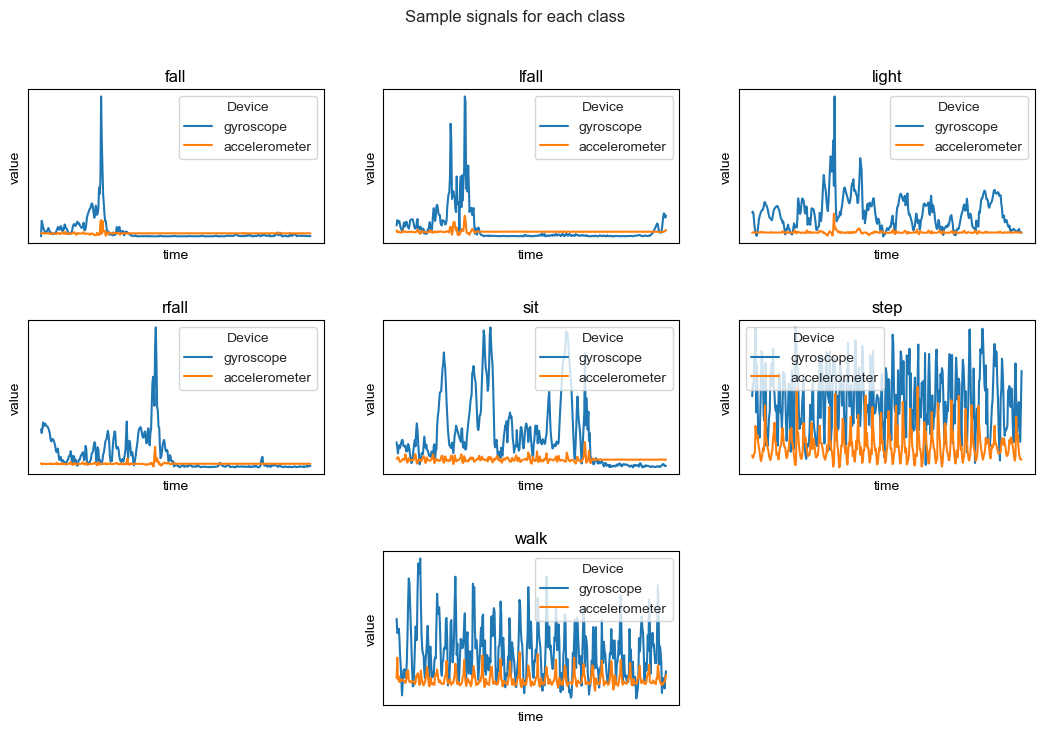

In [5]:
# Select one row for each different label class
sampled_rows = df.groupby('label').apply(lambda x: x.sample(1, random_state=123))

signal_plot(sampled_rows)

### FFT Magnitude

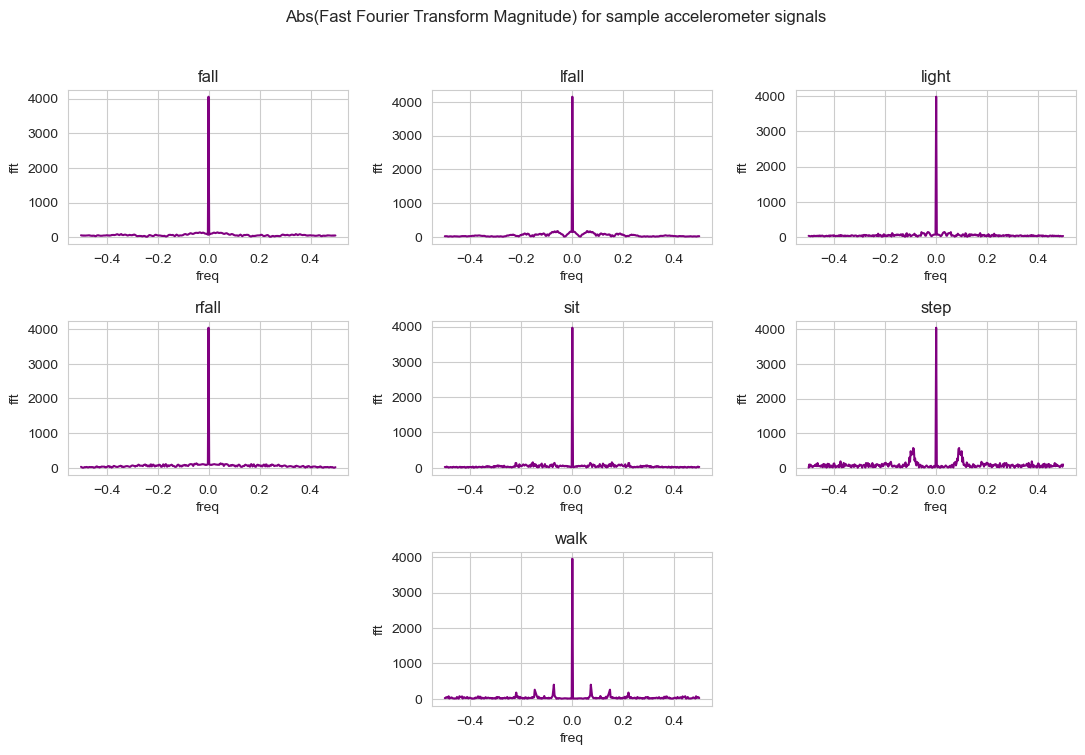

In [6]:
fft_plot(sampled_rows, "accelerometer")

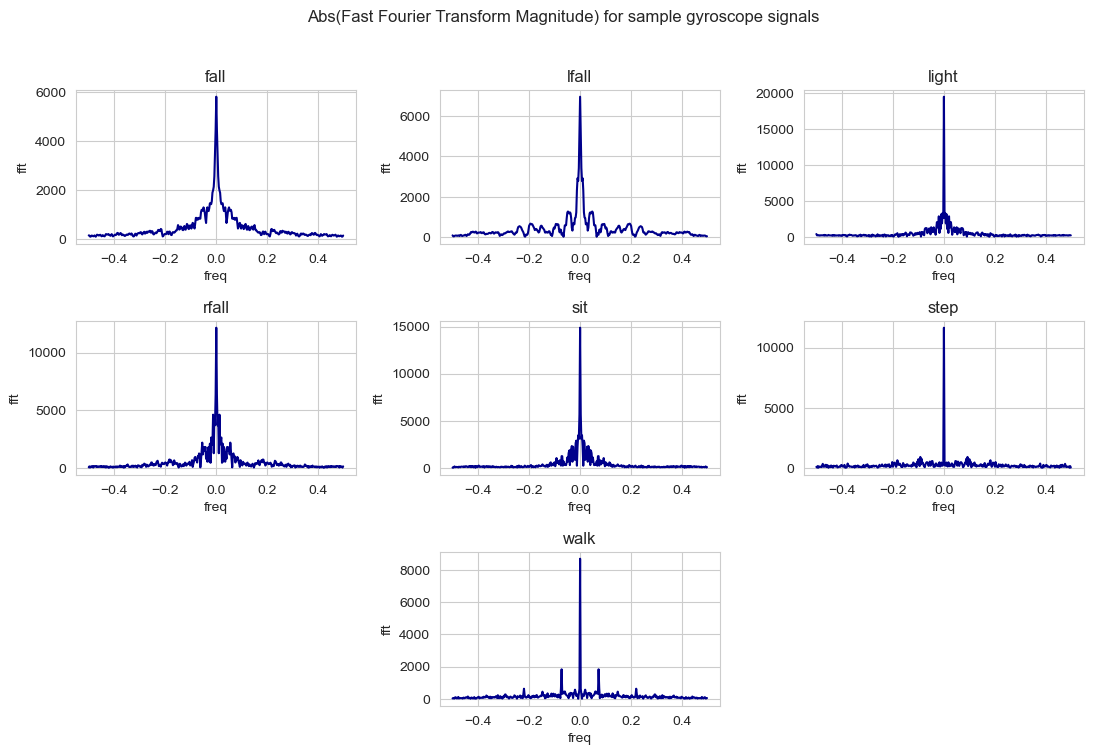

In [7]:
fft_plot(sampled_rows, "gyroscope")

### Power spectrum peaks

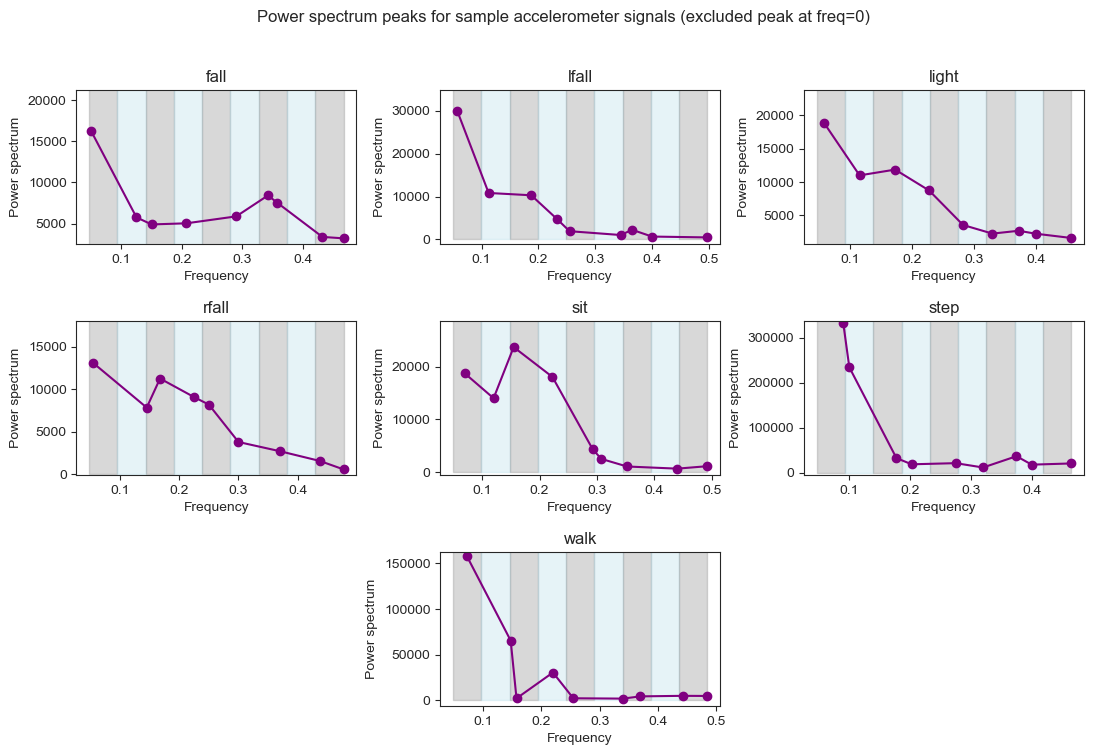

In [8]:
maxbin_plot(sampled_rows, "accelerometer")

Note that for the accelerometer the magnitude at frequence=0 is the same for each type of signal. This is not true for the gyroscope since it seems that for every signal has a peak at freq=0 BUT this peak has different magnitude in each case

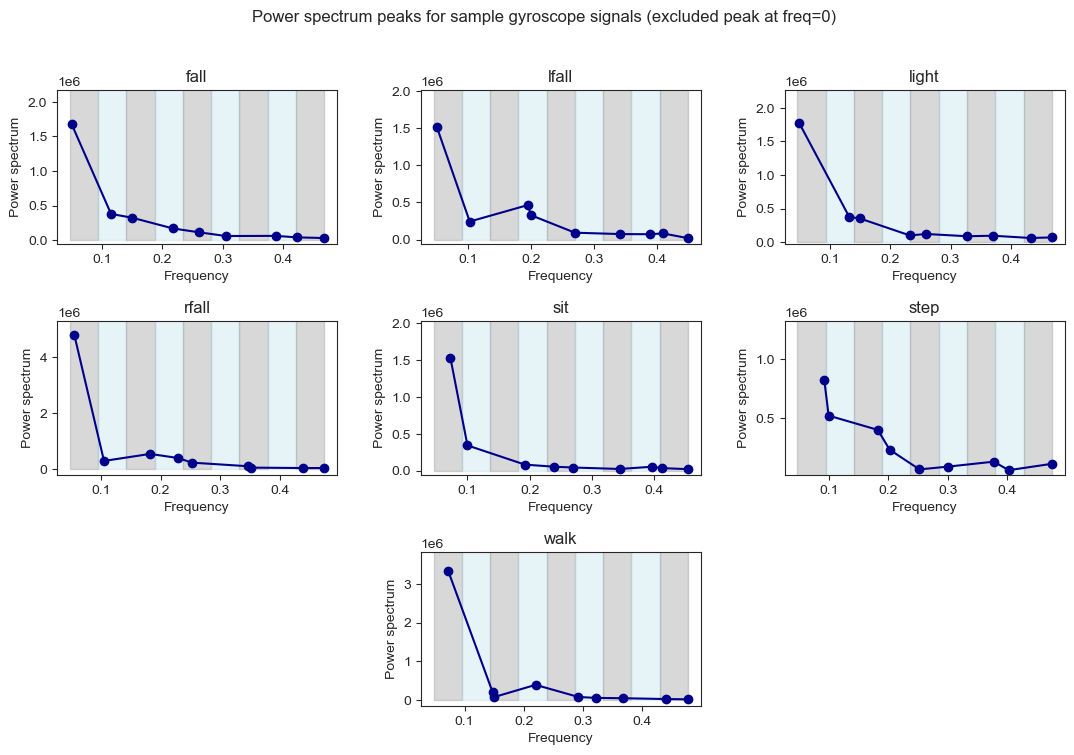

In [9]:
maxbin_plot(sampled_rows, "gyroscope")

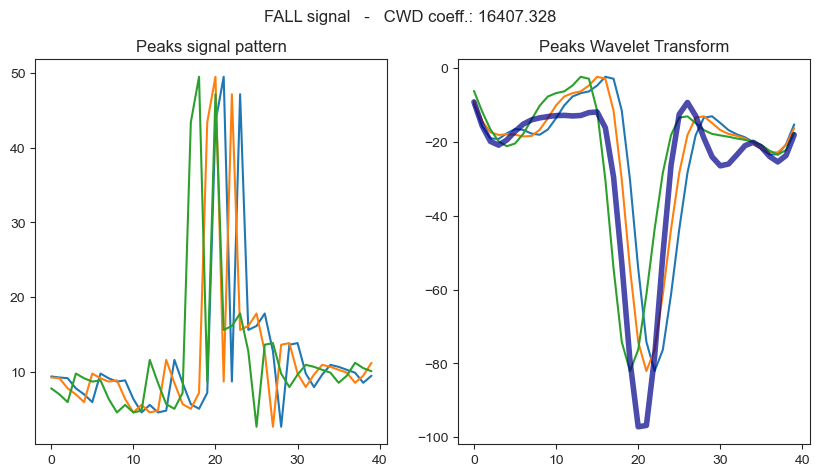

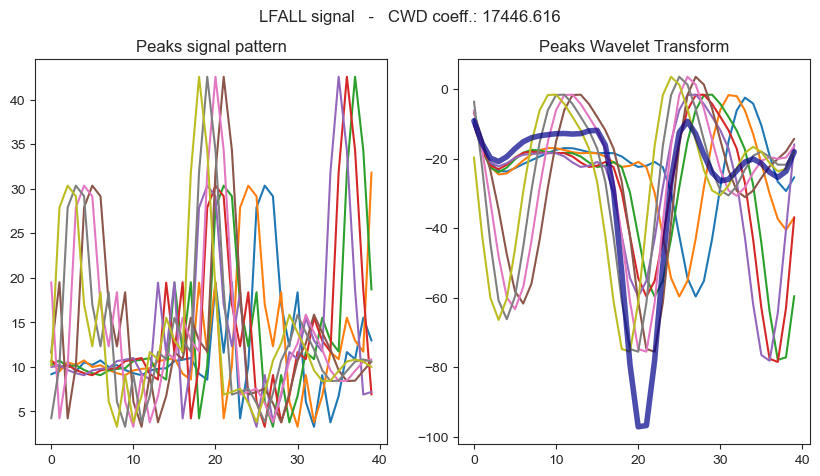

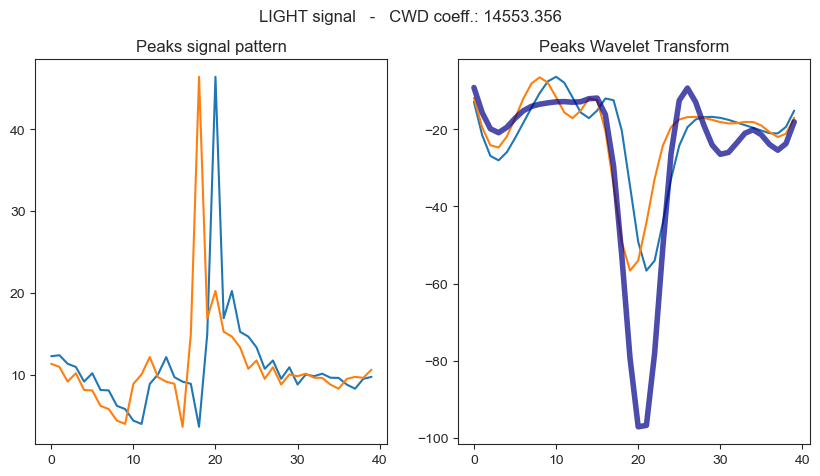

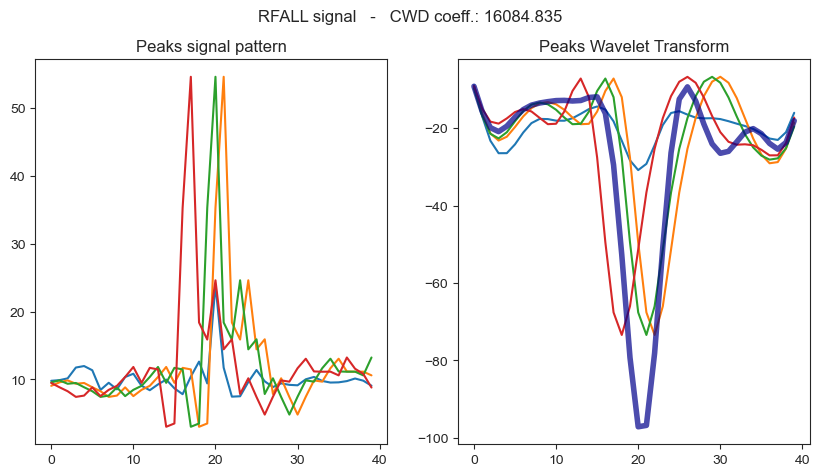

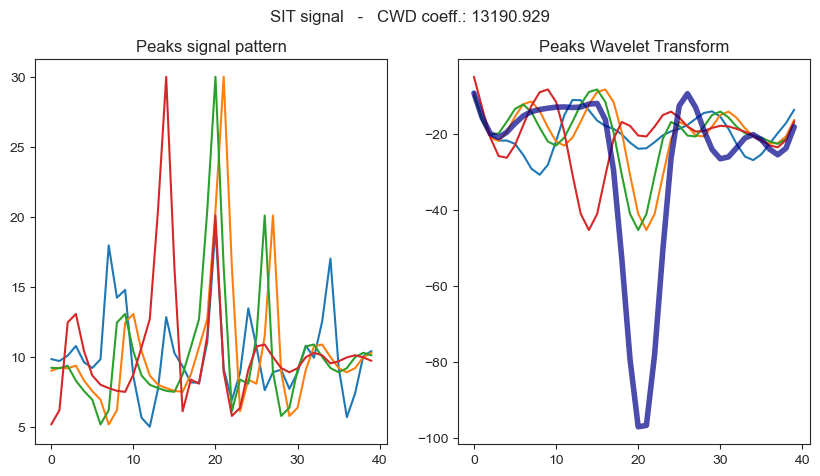

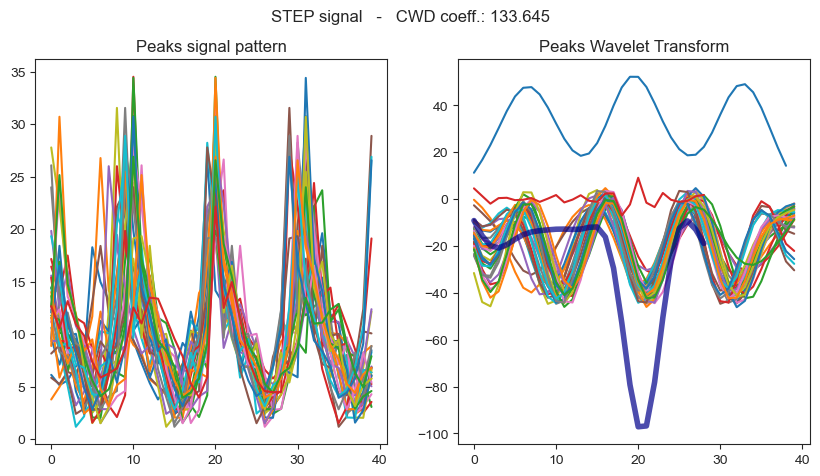

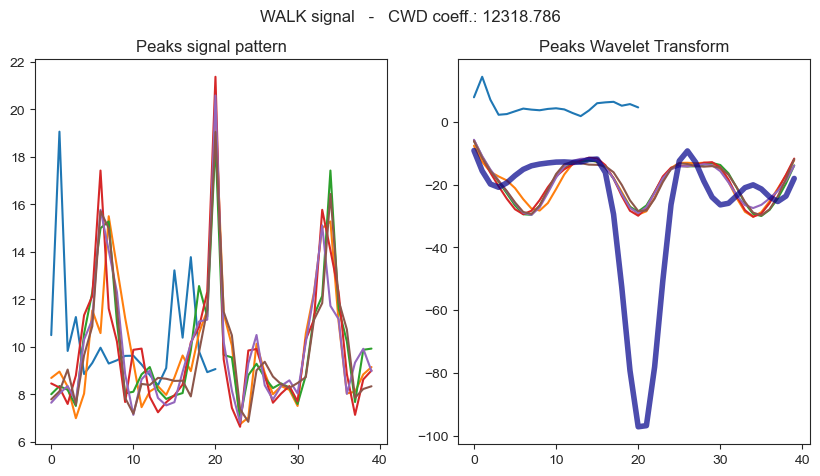

In [10]:
mother_wave = extract_wave_df("file_csv")

for label, row in sampled_rows.iterrows():
    vec = np.array(row[:-1], dtype=np.float32)[:400]
    res = peakes_wavelet_approx(vec, mother_wave, True, label[0])

## Final preprocessed data set

In [6]:
df = preproc(data, 15)
df

,acc_max_mag_1,acc_max_mag_2,acc_max_mag_3,acc_max_mag_4,acc_max_mag_5,gyr_max_mag_1,gyr_max_mag_2,gyr_max_mag_3,gyr_max_mag_4,gyr_max_mag_5,acc_psd1,acc_psd2,acc_psd3,gyr_psd1,gyr_psd2,gyr_psd3,cwt_coeff,label
0,1.679561e+07,18721.154353,7100.335747,15443.379045,11696.480495,1.077492e+08,5.017116e+06,6.787773e+05,2.100723e+05,511951.143950,7.264484,21.605317,2.266248,335.528281,6683.819118,10.060861,17895.547497,fall
1,1.666644e+07,17096.038339,5345.825318,22126.371544,16797.181146,2.970916e+08,5.963252e+06,1.876670e+06,6.657685e+05,465629.751594,9.428514,19.359462,1.741056,525.734259,8445.535938,12.842785,16992.656384,fall
2,1.690417e+07,22413.999497,14913.810039,18483.969593,13990.673765,4.304287e+08,8.412478e+06,1.644419e+06,7.335214e+05,671668.798449,11.073100,25.433874,1.874920,296.404199,6752.523845,8.763110,16037.018822,fall
3,1.690057e+07,18798.728822,27834.293492,58377.754093,30326.288200,5.162937e+08,9.091154e+06,1.965535e+06,6.057332e+05,683876.245125,9.131326,26.921273,3.127359,348.643022,8965.268444,10.819895,12731.303696,fall
4,1.742747e+07,17572.669139,99254.848523,124734.902539,34418.850456,3.574267e+08,3.717381e+06,2.053406e+06,1.452541e+06,843492.824657,12.425194,31.434656,6.207779,668.548802,6688.750331,9.785420,15162.129894,fall
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,1.638037e+07,20099.923295,7037.623252,11433.622947,7151.947063,3.005802e+08,1.076573e+07,3.910192e+06,7.194042e+05,389663.003137,6.840570,15.026079,2.081657,153.232435,4807.971407,5.426481,16233.858823,light
238,1.660464e+07,15692.281489,14302.864306,19305.212301,4545.408630,3.665159e+08,5.740845e+06,1.563710e+06,5.912486e+05,565309.135195,5.550793,11.241446,2.417584,227.597167,5924.778843,5.529446,12721.569249,light
239,1.612340e+07,25131.303791,14680.610706,5905.058076,7903.859218,2.961041e+08,5.159878e+06,1.533535e+06,1.211368e+06,795695.965727,10.788574,15.292856,2.242325,238.547673,5273.231796,5.532851,16415.380260,light
240,1.613424e+07,11934.645653,6998.180669,9199.815170,15515.727474,4.060575e+08,3.279267e+06,1.497185e+06,1.246336e+06,217021.252937,3.716582,11.827115,2.076557,203.839857,4587.081041,8.481311,15761.040305,light


In [9]:
df.columns

Index(['acc_max_mag_1', 'acc_max_mag_2', 'acc_max_mag_3', 'acc_max_mag_4',
       'acc_max_mag_5', 'gyr_max_mag_1', 'gyr_max_mag_2', 'gyr_max_mag_3',
       'gyr_max_mag_4', 'gyr_max_mag_5', 'acc_psd1', 'acc_psd2', 'acc_psd3',
       'gyr_psd1', 'gyr_psd2', 'gyr_psd3', 'cwt_coeff', 'label'],
      dtype='object')

In [7]:
labels = df["label"]
df_binary = df.copy()
df_new = df.copy()
df = df.drop("label", axis=1)

# Binary classification

Since we want to perform a binary classification, we have to map our seven classes onto two classes ("fall" or "normal"). Then we split the dataset into X_train and X_test set and the output vector into y_train and y_test. Then, we scale the the input matrix both in the train and test sets.

In [8]:
# Mapping for relabeling
label_mapping = {
    'fall' :'fall',
    'rfall': 'fall',
    'lfall': 'fall',
    'light': 'fall',
    'sit': 'normal',
    'walk': 'normal',
    'step': 'normal'
}

# Replace existing labels with new labels
df_binary['label'] = df_binary['label'].map(label_mapping)
y = df_binary["label"]
df_binary = df_binary.drop("label", axis=1)

# split data 
seed = 1218
X_train, X_test, y_train, y_test = train_test_split(df_binary, y, test_size=0.3, random_state=seed)

# scale the features (may be useful if we are going to add other features with different scale)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
X_test_scaled = scaler.fit_transform(X_test.astype(np.float64))

## Naive Bayes vs Logistic regression

In this section, we compare the performance of two models belonging to two different categories of machine learning models: discriminative and generative.
In brief, discriminative models target either to model $p(y|x)$ directly (i.e. as logistic regression does), or to learn a direct map from the inputs to the class variable (i.e. as perceptron does).
Generative models, on the other hand, try to model $p(x|y)$ and $p(y)$ (aka the likelihood and the prior distributions) and they make predictions by using the Bayes rule that allows to derive $p(y|x)$.


In this project, we compare the performance of logistic regression (representant of the discriminative category) and naive Bayes(representat of the generative category).
Naive Bayes models are a group of extremely fast and simple classification algorithms that are often suitable for very high-dimensional datasets. 
Naive Bayes models assume the conditional independency of the predictors, a very strong assumption that may not be true. 
Since naive Bayes models raise additional assumptions w.r.t. the logistic regression, they should be treated as a quick-and-dirty baseline for a classification problem.
In the cases where we do not have particular constraints in terms of both time/resources and information (number of observation), we should prevent fromm using this type of models.

There are many flavours of naive Bayes models but, for our purposes, we focus our attention on the Gaussian naive Bayes model. 
In this classifier, the assumption is that data from each label is drawn from a simple Gaussian distribution.
In order to fairly compare the performance of the naive Bayes and the logistic regression, we use a common procedure for the two models: a 10-fold cross validation with 10 repetitions.
This procedure allows us to obtain a more trustworthy accuracy measure.

We measure the accuracy of Gaussian naive bayes classifier using a reapeted K-fold cross validation.

In [132]:
# Prepare the cross-validation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=10,random_state=seed)
model = GaussianNB()
# Evaluate the model using cross-validation and accuracy scoring
scores = cross_val_score(model, X_train_scaled, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
# Calculate the mean of accuracy scores
mean_nb = scores.mean()
sd_nb = scores.std()
mean_nb

0.9727941176470588

Now, it is the turn of the logistic regression. Unlike naive Bayes, the logistic regression does not make any assumption on the distribution of the data. In fact, in the logistic regression we maximize the conditional likelihood of $Y$ given $X$ ,$Pr(Y|X)$, leaving unspecified the distribution of the inputs.
This implies that if the true class conditional distributions of data are Gaussian and conditionally independent given Y, the logistic regression will be asymptotically less efficient than naive Bayes.
Conversely, by making significantly weaker assumptions, logistic regression is more robust and less sensitive to incorrect modeling assumptions.

In [133]:
# Prepare the cross-validation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=10,random_state=seed)

# Create a logistic regression model
model = LogisticRegression()
# Evaluate the model using cross-validation and accuracy scoring
scores = cross_val_score(model, X_train_scaled, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

# Calculate the mean of accuracy scores
mean_lr = scores.mean()
sd_lr = scores.std()
mean_lr

0.9828676470588235

In [ ]:
fig = go.Figure()

# Add scatter traces for mean_nb and mean_lr
fig.add_trace(go.Scatter(
    x=[0, 0.5],
    y=[mean_nb, mean_lr],
    mode='markers',
    name='Means',
    error_y=dict(
        type='data',
        symmetric=False,
        array=[conf_nb[1] - mean_nb, conf_lr[1] - mean_lr],
        arrayminus=[mean_nb - conf_nb[0], mean_lr - conf_lr[0]]
    )
))

# Update x-axis properties
fig.update_xaxes(range=[-0.1, 0.6], tickvals=[0, 0.5], ticktext=['NB', 'LR'])

# Update x-axis properties
fig.update_yaxes(range=[0.8, 1.01])

fig.show()



We can see that the logistic regression outperforms the naive Bayes in terms of both bias and variance.
As it is explained in a famous paper published by Andrew Ng et al. in 2001, it has been proved that logistic regression outperforms naive Bayes with a large number of training samples.
However, the generative model reaches its asymptotic faster (O(log n)) than the discriminative model(O (n))

## Model comparison in binary classification

### The models

In [105]:
print("Logistic")
log_preds, log_clf = best_softmax_fit(X_train_scaled, X_test_scaled, y_train, y_test, binary=True)
print("*"*200)
print("Random Forest")
rf_preds, rf_clf = best_rf_fit(X_train_scaled, X_test_scaled, y_train, y_test)
print("*"*200)
print("SVM")
svm_preds, svm_clf = best_svm_fit(X_train_scaled, X_test_scaled, y_train, y_test)
print("*"*200)
print("XGBoost")
le = LabelEncoder()
le.fit(y_train.unique())
warnings.filterwarnings('ignore')
y_tr = le.transform(y_train)
y_te = le.transform(y_test)
xgb_preds, xgb_clf = best_xgboost_fit(X_train_scaled, X_test_scaled, y_tr, y_te, binary=True)
print("*"*200)
print("ADAboost")
ada_preds, ada_clf = best_ada_fit(X_train_scaled, X_test_scaled, y_train, y_test)
print("*"*200)
print("KNN")
knn_preds, knn_clf = best_knn_fit(X_train_scaled, X_test_scaled, y_train, y_test)
print("*"*200)
print("Perceptron")
perc_preds, perc_clf = best_perc_fit(X_train_scaled, X_test_scaled, y_train, y_test)

Logistic
Best parameters: {'warm_start': True, 'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 550, 'fit_intercept': False, 'class_weight': None}
Accuracy:1.0
F1-score:1.0
********************************************************************************************************************************************************************************************************
Random Forest
Best parameters: {'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': 100, 'criterion': 'entropy', 'bootstrap': False}
Accuracy:0.9863013698630136
F1-score:0.9862910798122064
********************************************************************************************************************************************************************************************************
SVM
Best parameters: {'shrinking': False, 'kernel': 'sigmoid', 'degree': 10, 'decision_function_shape': 'ovr', 'break_ties': True, 'C': 1}
Accuracy:0.958904109589041
F1-score:0.958904109589041
**********************************

In [101]:
clf_list = [
    (log_clf, log_preds, "Logistic"),
    (rf_clf, rf_preds, "Random Forest"),
    (svm_clf, svm_preds, "SVM"),
    (ada_clf, ada_preds, "ADAboost"),
    (knn_clf, knn_preds, "KNN")
]

### Performance metrics

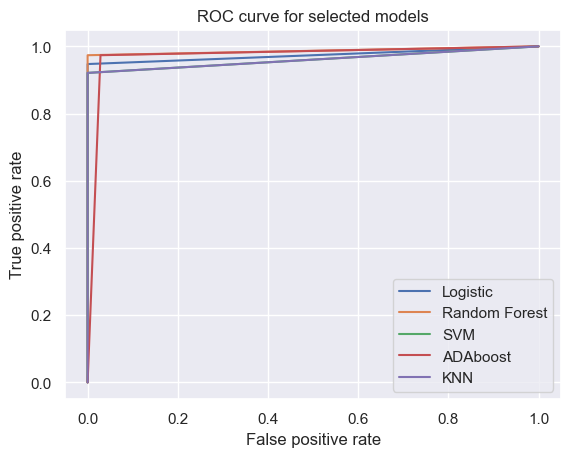

In [110]:
metrics = model_comparison(clf_list, X_test_scaled, y_te, le)

In [111]:
metrics = pd.DataFrame(metrics)
metrics

,model,recall,precision,f1-score,accuracy,roc-auc
0,Logistic,0.973684,0.972973,0.972598,0.972603,0.973684
1,Random Forest,0.986842,0.986111,0.986291,0.986301,0.986842
2,SVM,0.960526,0.960526,0.958904,0.958904,0.960526
3,ADAboost,0.972556,0.972556,0.972556,0.972603,0.972556
4,KNN,0.960526,0.960526,0.958904,0.958904,0.960526


### Calibration curves for the binary classification

Well calibrated classifiers are probabilistic classifiers for which the output of predict_proba can be directly interpreted as a confidence level. For instance, a well calibrated (binary) classifier should classify the samples such that for the samples to which it gave a predict_proba value close to 0.8, approximately 80% actually belong to the positive class.

We will compare the calibration curves (also known as reliability diagrams) IN THIS SETUP:
>- using the above classifiers
>- fitting these classifiers on modified data set, reducing the problem to a binary classification (we collapse the labels in 2 classes)
>- using predicted probabilities of the test dataset.

Calibration curves are then created by binning predicted probabilities, then plotting the mean predicted probability in each bin against the observed frequency (fraction of positives).

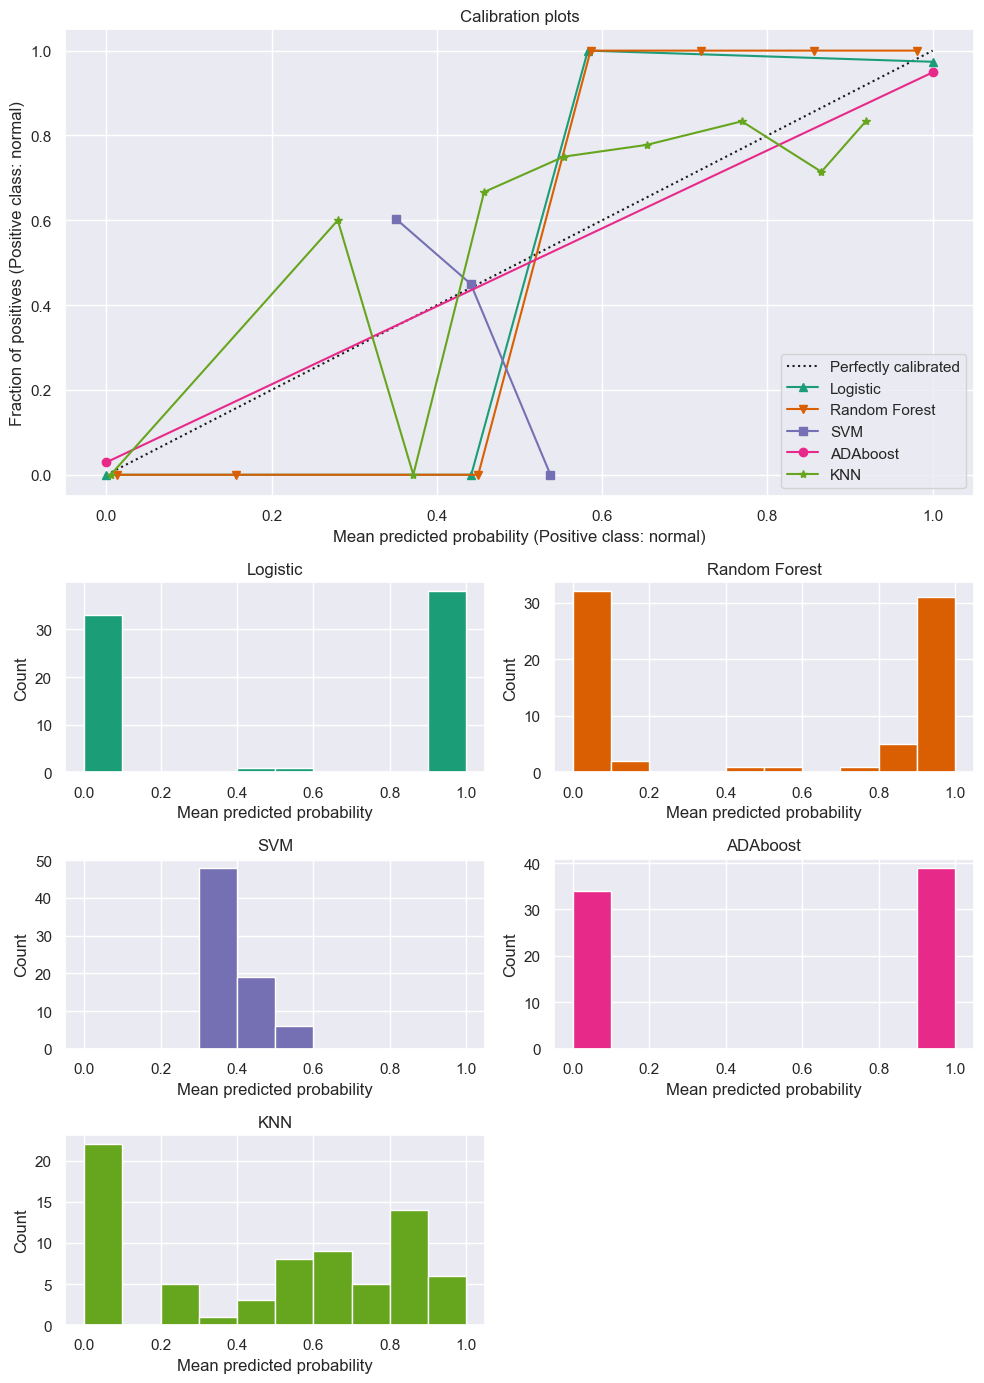

In [112]:
from matplotlib.gridspec import GridSpec
from sklearn.calibration import CalibrationDisplay

sns.set()
fig = plt.figure(figsize=(10, 14))
gs = GridSpec(5, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
markers = ["^", "v", "s", "o", "*", "p"]
for i, (clf, _, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
        marker=markers[i],
    )
    calibration_displays[name] = display

ax_calibration_curve.set_title("Calibration plots")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1), (4, 0), (4,1)]
for i, (_, _, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()


# Multi-class

## Linear classifiers multi-class with SGD


Stochastic Gradient Descent (SGD) is a simple yet very efficient approach to fitting linear classifiers and regressors under convex loss functions such as (linear) Support Vector Machines and Logistic Regression. Strictly speaking, SGD is merely an optimization technique and does not correspond to a specific family of machine learning models. It is only a way to train a model.


The advantages of Stochastic Gradient Descent are:

- Efficiency.

- Ease of implementation (lots of opportunities for code tuning).

The disadvantages of Stochastic Gradient Descent include:

- SGD requires a number of hyperparameters such as the regularization parameter and the number of iterations.

- SGD is sensitive to feature scaling.

We must be sure of permuting (shuffle) training data before fitting the model or use shuffle=True to shuffle after each iteration (used by default) because in these optimization algorithms, only a subset (mini-batch) of the data is used in each iteration. Shuffling ensures that each mini-batch is a random sample from the dataset, reducing the chance of biased updates and making the optimization process more stable.

SGDClassifier supports multi-class classification by combining multiple binary classifiers in a “one versus all” (OVA) scheme. For each of the classes, a binary classifier is learned that discriminates between that and all other classes. At testing time, we compute the confidence score (i.e. the signed distances to the hyperplane) for each classifier and choose the class with the highest confidence. The figure below illustrates the OVA approach on the on our dataset considering only 2 features to visualize a 2-d plot. The dashed lines represent the seven OVA classifiers; the background colors show the decision surface induced by the seven classifiers. We used deafult options for the classifiers, only to show how it works. 


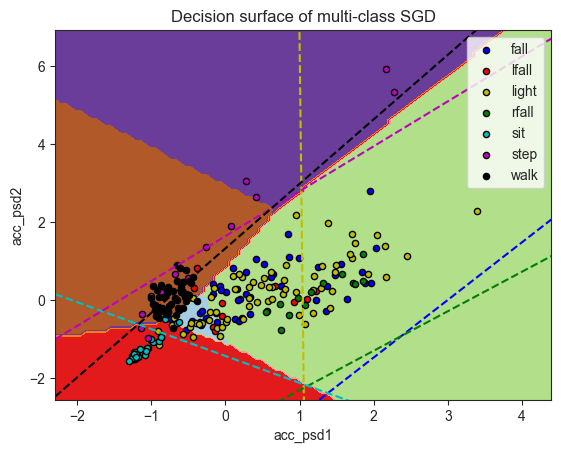

In [ ]:
# Create a mapping of class labels to integers
class_label_mapping = {label: idx for idx, label in enumerate(np.unique(y))}
# Convert class labels to integers
y_int = np.array([class_label_mapping[label] for label in y])

# Extract the features for plotting
X = df[['acc_psd1', 'acc_psd2']]  # Replace with your actual column names

# Shuffle
idx = np.arange(X.shape[0])
np.random.seed(13)
np.random.shuffle(idx)
X = X.iloc[idx]
y_int = y_int[idx]

# Standardize
mean = X.mean(axis=0)
std = X.std(axis=0)
X = (X - mean) / std

clf = SGDClassifier(alpha=0.001, max_iter=100).fit(X, y_int)
ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
    clf,
    X,
    cmap=plt.cm.Paired,
    ax=ax,
    response_method="predict",
    xlabel='acc_psd1',
    ylabel='acc_psd2',  # Replace with your feature names
)
plt.axis("tight")

# Define a list of colors for each class
colors = ["b", "r", "y", "g", "c", "m", "k"]  # Add more colors as needed

# Get the unique class labels from 'y'
unique_labels = np.unique(y)

# Plot the training points for each class with actual labels
for i, color, label in zip(np.unique(y_int), colors, unique_labels):
    plt.scatter(
        X[y_int == i]['acc_psd1'],
        X[y_int == i]['acc_psd2'],
        c=color,
        label=label,  # Use actual class label from 'y'
        cmap=plt.cm.Paired,
        edgecolor="black",
        s=20,
    )
plt.title("Decision surface of multi-class SGD")
plt.axis("tight")

xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
coef = clf.coef_
intercept = clf.intercept_

def plot_hyperplane(c, color):
    def line(x0):
        return (-(x0 * coef[c, 0]) - intercept[c]) / coef[c, 1]

    plt.plot([xmin, xmax], [line(xmin), line(xmax)], ls="--", color=color)
for c, color in zip(clf.classes_, colors):
    plot_hyperplane(int(c), color)  # Convert class label to integer for indexing

# Move the legend to the top-right corner
plt.legend(loc='upper right')

plt.show()


### Classes Imbalanced

In [136]:
y = labels
y.value_counts()

light    69
walk     48
fall     47
sit      40
step     15
rfall    13
lfall    10
Name: label, dtype: int64

We collected the data in a simulated manner and have unbalanced classes, but even generally, in the real world this is a problem that will present unbalanced classes, where we have a situation where one or more classes have significantly fewer samples than others. In this case, we have to be cautious during model training and evaluation to ensure that the model doesn't just predict the majority class, so some validation technique and evaluation metric must be used to account for this. 

### Repeated Stratified K-fold Validation

Stratified k-fold cross-validation can be a valuable technique to help evaluate a model when dealing with imbalanced datasets or when certain classes have relatively fewer samples. Here's how stratified k-fold validation can help in this scenario:

- **Preserving Class Distribution**: Stratified cross-validation ensures that each fold maintains the same class distribution as the original dataset. This is crucial because it prevents any one class from being underrepresented or completely excluded from certain folds, ensuring that the model is evaluated fairly across all classes.

- **Mitigating Bias**: Without stratification, random sampling for cross-validation folds might lead to some folds containing an insufficient number of samples from minority classes. This can result in biased performance estimates, especially for those minority classes. Stratified k-fold CV mitigates this bias by ensuring that each fold is representative of the overall class distribution.

- **Robustness in Model Evaluation**: Repeated k-fold cross-validation is known for its robustness in estimating model performance. When combined with stratification, it becomes even more robust, as it repeatedly ensures that all classes are adequately represented across different folds and repetitions. This robustness is essential for making reliable decisions about model selection and hyperparameter tuning. Metrics such as precision, recall, F1-score, or area under the Receiver Operating Characteristic curve (AUC-ROC) can give a better understanding of how well the model performs, particularly for minority classes.

- **Parameter Tuning**: When tuning hyperparameters or selecting models, stratified cross-validation can help in making more informed decisions. It ensures that the model is tested and validated on different combinations of data, which is important for robust model selection.

- **Generalization**: Stratified k-fold CV helps assess how well the model generalizes to unseen data, which is crucial for real-world applications. It provides a more realistic estimate of how the model might perform when applied to new data with imbalanced class distributions.

The class SGDClassifier in Python implements a plain stochastic gradient descent learning routine which supports different loss functions and penalties for classification and we will try some of them.

### Mathematical formulation

Given a set of training examples $(y_i, x_i),...,(y_n,x_n)$ where $x_i \in R^m$ and $y_i \in R (y_i \in -1,1$, for classification) , our goal is to learn a linear scoring function $f(x)=w^Tx+b$ with model parameters $w \in R^m$ and intercept $b \in R$. In order to make predictions for binary classification, we simply look at the sign of $f(x)$. To find the model parameters, we minimize the regularized training error given by 
$$ E(w,b)=\frac{1}{n}\sum\limits_{i=1}^n L(y_i,f(x_i))+\alpha R(w) $$

where $L$ is a loss function that measures model (mis)fit and $R$ is a regularization term (aka penalty) that penalizes model complexity; $\alpha>0$ is a non-negative hyperparameter that controls the regularization strength. 
Different choices for entail different classifiers or regressors:

### Evaluation Metric
The main evaluation metric is the Balanced Accuracy Score (BAS). The score ranges from 0 to 1 with performance at random scoring 0.
The BAS, avoids inflated performance estimates on imbalanced datasets. The BAS is the macro-average of recall scores per class or, equivalently, raw accuracy where each sample is weighted according to the inverse prevalence of its true class. Thus for balanced datasets, the score is equal to accuracy.

In [ ]:
# split data 
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.25)

### LOGISTIC REGRESSION 

$L : Log Loss = L(y_i,f(x_i)) = log(1+exp(-y_if(x_i)))$



In [ ]:
log_preds = fit_linear_model(X_train, X_test,y_train, 'log', 'balanced_accuracy')

Best Hyperparameters: {'alpha': 0.01, 'class_weight': 'balanced', 'penalty': 'l2'}
Accuracy: 0.87
Balanced Accuracy: 0.74
Classification Report:
               precision    recall  f1-score   support

        fall       0.82      0.75      0.78        12
       lfall       0.20      0.50      0.29         2
       light       1.00      0.95      0.98        22
       rfall       0.00      0.00      0.00         3
         sit       1.00      1.00      1.00         8
        step       1.00      1.00      1.00         2
        walk       1.00      1.00      1.00        12

    accuracy                           0.87        61
   macro avg       0.72      0.74      0.72        61
weighted avg       0.89      0.87      0.88        61



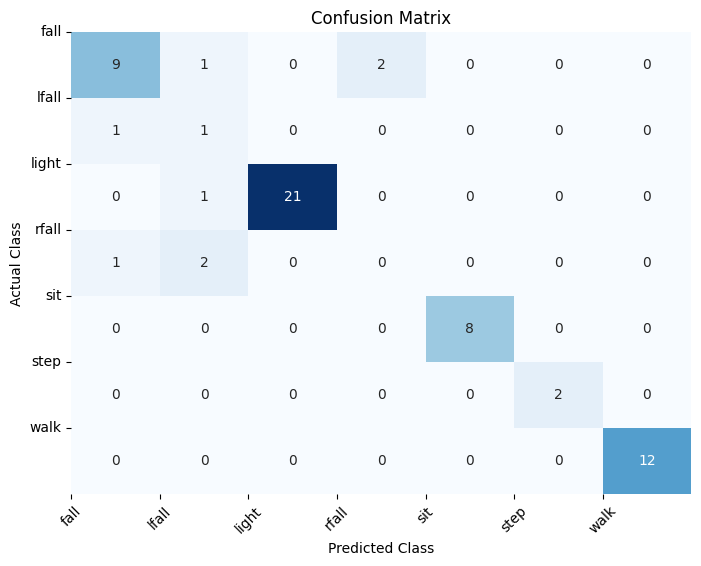

In [ ]:
show_results(y_test, log_preds)

### HINGE LOSS

$L:Hinge(soft-margin):$ equivalent to Support Vector Classification.

$L(y_i,f(x_i))= max(0,1-y_if(x_i))$

In [ ]:
hinge_preds = fit_linear_model(X_train,X_test,y_train, 'hinge', 'balanced_accuracy')

Best Hyperparameters: {'alpha': 0.01, 'class_weight': 'balanced', 'penalty': 'l1'}
Accuracy: 0.90
Balanced Accuracy: 0.80
Classification Report:
               precision    recall  f1-score   support

        fall       0.83      0.83      0.83        12
       lfall       0.50      0.50      0.50         2
       light       1.00      1.00      1.00        22
       rfall       0.33      0.33      0.33         3
         sit       0.89      1.00      0.94         8
        step       1.00      1.00      1.00         2
        walk       1.00      0.92      0.96        12

    accuracy                           0.90        61
   macro avg       0.79      0.80      0.79        61
weighted avg       0.90      0.90      0.90        61



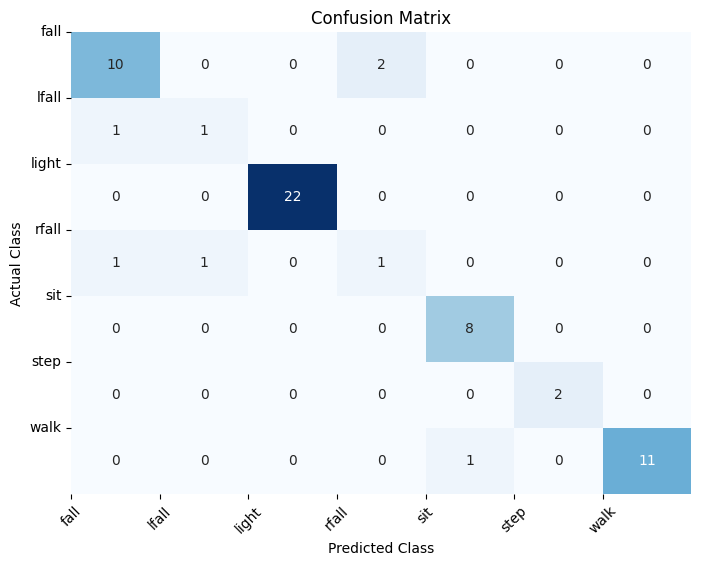

In [ ]:
show_results(y_test, hinge_preds)

### SQUARED HINGE

In [ ]:
squared_hinge = fit_linear_model(X_train,X_test,y_train, 'squared_hinge', 'balanced_accuracy')

Best Hyperparameters: {'alpha': 0.0001, 'class_weight': 'balanced', 'penalty': 'l1'}
Accuracy: 0.82
Balanced Accuracy: 0.75
Classification Report:
               precision    recall  f1-score   support

        fall       0.78      0.58      0.67        12
       lfall       0.20      0.50      0.29         2
       light       1.00      0.86      0.93        22
       rfall       0.20      0.33      0.25         3
         sit       1.00      1.00      1.00         8
        step       0.67      1.00      0.80         2
        walk       1.00      1.00      1.00        12

    accuracy                           0.82        61
   macro avg       0.69      0.75      0.70        61
weighted avg       0.88      0.82      0.84        61



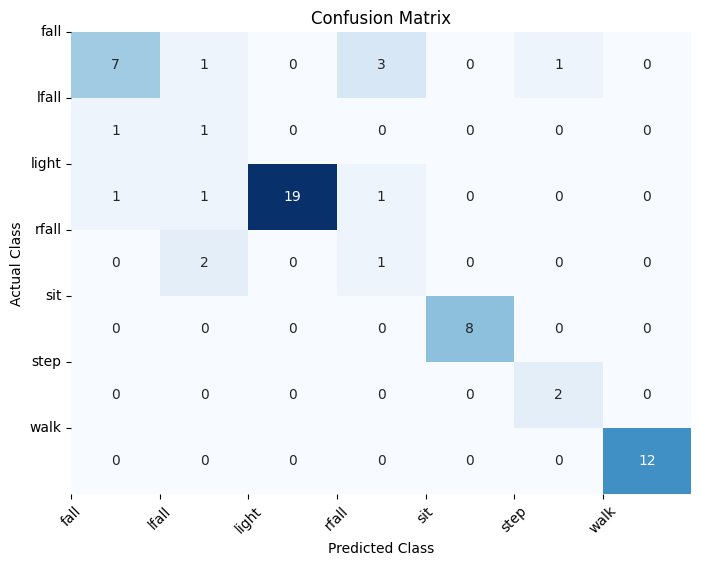

In [ ]:
show_results(y_test,squared_hinge)

### PERCEPTRON

$L: Perceptron = L(y_i,f(x_i))= max(0,-y_if(x_i))$

In [ ]:
perceptron_preds = fit_linear_model(X_train,X_test,y_train, 'perceptron', 'balanced_accuracy')

Best Hyperparameters: {'alpha': 0.0001, 'class_weight': 'balanced', 'penalty': 'l1'}
Accuracy: 0.85
Balanced Accuracy: 0.76
Classification Report:
               precision    recall  f1-score   support

        fall       0.86      0.50      0.63        12
       lfall       0.25      0.50      0.33         2
       light       1.00      1.00      1.00        22
       rfall       0.25      0.33      0.29         3
         sit       1.00      1.00      1.00         8
        step       0.50      1.00      0.67         2
        walk       1.00      1.00      1.00        12

    accuracy                           0.85        61
   macro avg       0.69      0.76      0.70        61
weighted avg       0.89      0.85      0.86        61



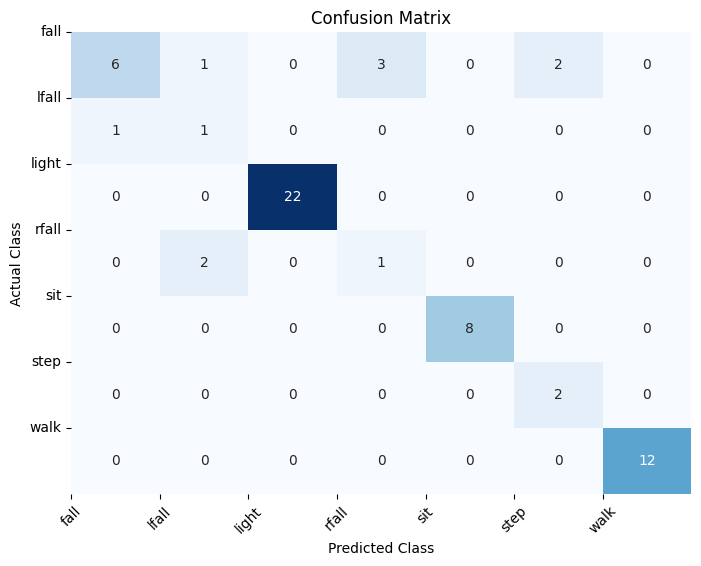

In [ ]:
show_results(y_test,perceptron_preds)

### MODFIED HUBER

$L: Modified Huber = L(y_i,f(x_i)) = max(0,1-y_if(x_i))^2 ify_if(x_i)>1,$ and $L(y_i,f(x_i)) = -4y_if(x_i))$ otherwise

In [ ]:
modified_huber_preds = fit_linear_model(X_train,X_test,y_train, 'modified_huber', 'balanced_accuracy')

Best Hyperparameters: {'alpha': 0.001, 'class_weight': 'balanced', 'penalty': 'l1'}
Accuracy: 0.82
Balanced Accuracy: 0.68
Classification Report:
               precision    recall  f1-score   support

        fall       0.75      0.50      0.60        12
       lfall       0.00      0.00      0.00         2
       light       1.00      0.95      0.98        22
       rfall       0.17      0.33      0.22         3
         sit       1.00      1.00      1.00         8
        step       0.67      1.00      0.80         2
        walk       1.00      1.00      1.00        12

    accuracy                           0.82        61
   macro avg       0.65      0.68      0.66        61
weighted avg       0.87      0.82      0.84        61



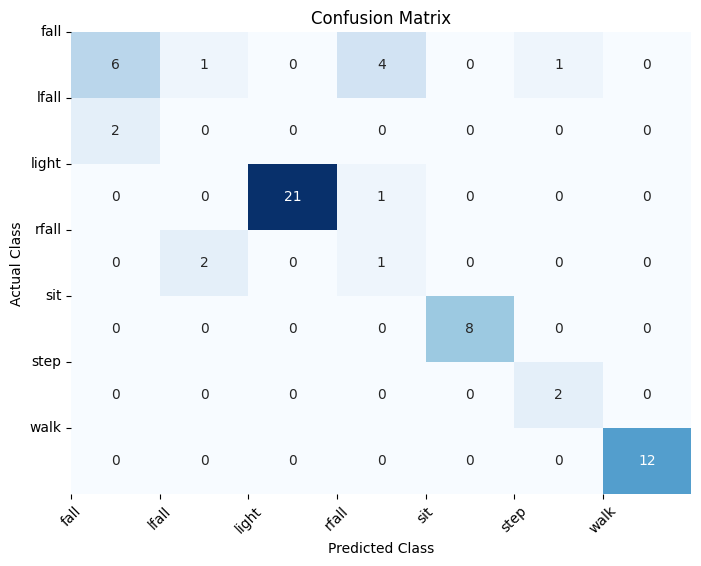

In [ ]:
show_results(y_test,modified_huber_preds)

## QDA and LDA

Both LDA and QDA can be derived from simple probabilistic models which model the class conditional distribution of the data $P(X|y=k)$ for each class k. Predictions can then be obtained by using Bayes’ rule, for each training sample $x \in R^d$:

$$P(y=k|x)=\frac{P(x|y=k)P(y=k)}{P(x)} = \frac{P(x|y=k)P(y=k)}{\sum_l P(x|y=l)*P(y=l)} $$

and we select the class which maximizes this posterior probability.

More specifically, for linear and quadratic discriminant analysis, P(x|y) is modeled as a multivariate Gaussian distribution with density:

$$P(x|y=k)= \frac{1}{(2\pi)^{d/2}|\Sigma_k|^{1/2}}\exp(-\frac{1}{2}(x-\mu_k)^t\Sigma_k^{-1}(x-\mu_k))$$

where d is the number of features.

### Quadratic discriminant analysis

According to the model above, the log of the posterior is:

$$ log P(y=k|x)= logP(x|y=k)+logP(y=k)+Cst =-\frac{1}{2}log|\Sigma_k|-\frac{1}{2}(x-\mu_k)^t\Sigma_k^{-1}(x-\mu_k)+logP(y=k)+Cst$$

where the constant term Cst corresponds to the denominator P(x), in addition to other constant terms from the Gaussian. The predicted class is the one that maximises this log-posterior.

**Relation with Gaussian Naive Bayes**

If in the QDA model one assumes that the covariance matrices are diagonal, then the inputs are assumed to be conditionally independent in each class, and the resulting classifier is equivalent to the Gaussian Naive Bayes classifier.

Best Hyperparameters: {}
Accuracy: 0.62
Balanced Accuracy: 0.34
Classification Report:
               precision    recall  f1-score   support

        fall       0.59      0.83      0.69        12
       lfall       0.00      0.00      0.00         2
       light       0.56      0.91      0.69        22
       rfall       0.00      0.00      0.00         3
         sit       0.00      0.00      0.00         8
        step       0.00      0.00      0.00         2
        walk       1.00      0.67      0.80        12

    accuracy                           0.62        61
   macro avg       0.31      0.34      0.31        61
weighted avg       0.51      0.62      0.54        61



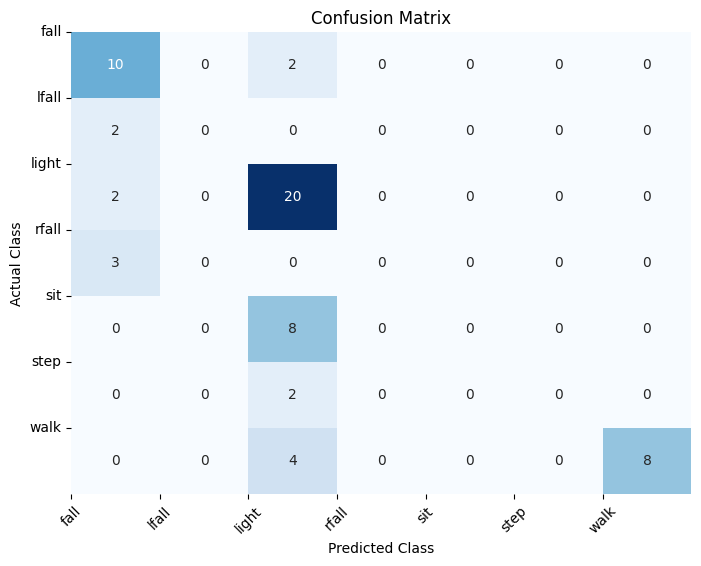

In [ ]:
# Call the function to fit and evaluate the QDA model
qda_fit = fit_qda_model(X_train,X_test, y_train, 'balanced_accuracy')

# Call the show_results function to display the evaluation metrics
show_results(y_test, qda_fit)


### Linear Discriminant Analysis

LDA is a special case of QDA, where the Gaussians for each class are assumed to share the same covariance matrix: $\Sigma_k=\Sigma$ for all k. This reduces the log posterior to:

$$logP(y=k|x)=-\frac{1}{2}(x-\mu_k)^t\Sigma^{-1}(x-\mu_k)+logP(y=k)+Cst$$

The term $(x-\mu_k)^t\sum^{-1}(x-\mu_k)$ corresponds to the Mahalanobis Distance between the sample and the mean $\mu_k$. The Mahalanobis distance tells how close $x$ is from $\mu_k$, while also accounting for the variance of each feature. We can thus interpret LDA as assigning $x$ to the class whose mean is the closest in terms of Mahalanobis distance, while also accounting for the class prior probabilities.

The log-posterior of LDA can also be written as:
$$logP(y=k|x)=\omega_k^tx+\omega_{k0}+Cst$$

where $\omega_k=\Sigma^{-1}\mu_k$ and $\omega_{k0} = -\frac{1}{2}\mu_k^t\Sigma^{-1}\mu_k+logP(y=k)$

These quantities correspond to the coef_ and intercept attributes, respectively. From the above formula, it is clear that LDA has a linear decision surface.

Assumption (A.lda): 

in each class k the joint distribution of the features is a multivariate normal centred on the mean vector $\mu_k$ , and
having a covariance matrix $\Sigma$ common to all classes, i.e.

$$X|Y=k \sim N(\mu_k ;\Sigma) \text{ for each k} = 1,2,...,K$$

Implications:

- the class conditional densities are $f_k (x) = (x;\mu_k ;\Sigma)$
- the scatter of the points in each class have elliptic-symmetric form
- since the features have covariance matrix in each class,
the assumption (A.lda) implies that in all classes the scatter of the
features has homogeneous geometric characteristics

LDA is also a 'linear classification method' because it produces linear decision boundaries. It can be shown that the LDA produces decision boundaries between classes that consist of straight lines (if p = 2), planes (p = 3), hyper-planes (when p > 3, as in our case).

Best Hyperparameters: {'shrinkage': None, 'solver': 'lsqr'}
Accuracy: 0.87
Balanced Accuracy: 0.72
Classification Report:
               precision    recall  f1-score   support

        fall       0.75      0.75      0.75        12
       lfall       0.00      0.00      0.00         2
       light       1.00      0.95      0.98        22
       rfall       0.33      0.33      0.33         3
         sit       1.00      1.00      1.00         8
        step       1.00      1.00      1.00         2
        walk       1.00      1.00      1.00        12

    accuracy                           0.87        61
   macro avg       0.73      0.72      0.72        61
weighted avg       0.89      0.87      0.88        61



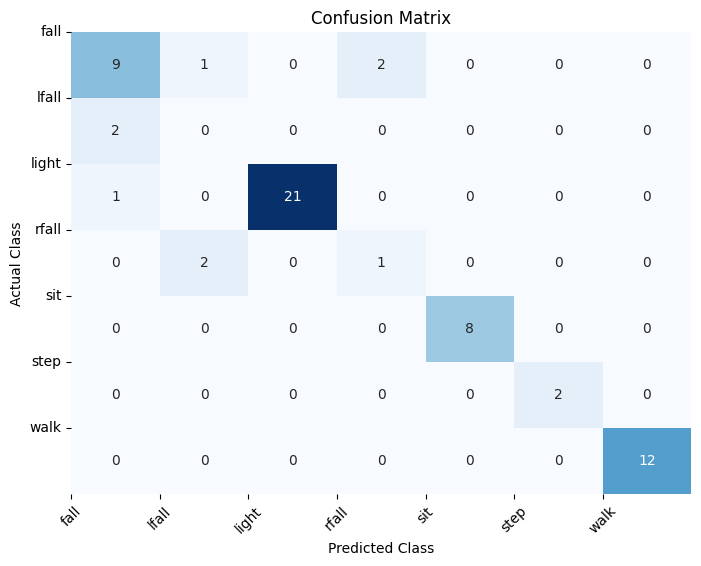

In [ ]:
# Call the function to fit and evaluate the LDA model
lda_fit = fit_lda_model(X_train,X_test, y_train, 'balanced_accuracy')

# Call the show_results function to display the evaluation metrics
show_results(y_test, lda_fit)

## Softmax regression

In [18]:
# labels
y = labels
seed = 1218
# split data 
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.3, random_state=seed)

# scale the features (may be useful if we are going to add other features with different scale)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.astype(np.float64))
X_test = scaler.fit_transform(X_test.astype(np.float64))


We simply fit of a Softmax regression since we have seven different classes that we want to predict. So we specify the "multinomial" attribute for our Scikit-learn model, and we use the "lbfgs" (Limited-memory BFGS) optimization algorithm as solver with $L_2$ default regularization

In [97]:
# softmax regression
softmax = LogisticRegression(multi_class="multinomial", solver="lbfgs")
softmax.fit(X_train, y_train)
sm_preds = softmax.predict(X_test)

accuracy_score(y_test, sm_preds)

0.9041095890410958

Let's compare our results without regularization... the model seems to not well generalize... so it is better to insist with l2 penalty (the only one "legal" in combo with our solver). 

In [98]:
softmax_nr = LogisticRegression(multi_class="multinomial", solver="lbfgs", penalty=None)
softmax_nr.fit(X_train, y_train)
sm_preds1 = softmax_nr.predict(X_test)

accuracy_score(y_test, sm_preds1)

0.821917808219178

We can try to inspect the generalization performances (approximated by a K-Fold Cross-Validation) for different values of the penalization coefficient $\lambda$ in the the Ridge Classifier. The results show that, on average, the performance in terms of accuracy is maximized relatively slow levels of penalization coefficient.

(0.0, 400.0)

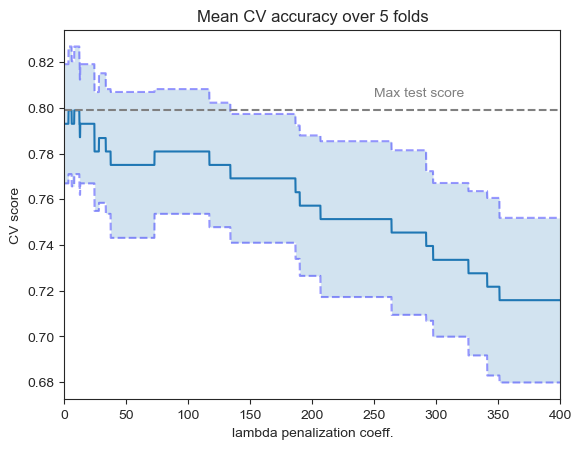

In [64]:
ridge = RidgeClassifier()

lambdas = np.linspace(0, 400, 5000)

params = [{"alpha": lambdas}]
n_folds = 5

lambda_CV = GridSearchCV(ridge, params, cv=n_folds, refit=False)
lambda_CV.fit(X_train, y_train)
scores = lambda_CV.cv_results_["mean_test_score"]
scores_std = lambda_CV.cv_results_["std_test_score"]
std_error = scores_std / np.sqrt(n_folds)

plt.plot(lambdas, scores)
plt.plot(lambdas, scores + std_error, "b--", alpha=0.4)
plt.plot(lambdas, scores - std_error, "b--", alpha=0.4)
plt.fill_between(lambdas, scores + std_error, scores - std_error, alpha=0.2)
plt.text(250, 0.805, "Max test score", color="grey")
plt.title(f'Mean CV accuracy over {n_folds} folds')
plt.ylabel("CV score")
plt.xlabel("lambda penalization coeff.")
plt.axhline(np.max(scores), linestyle="--", color=".5")
plt.xlim([lambdas[0], lambdas[-1]])

With this initial analysis we may simply restrict the parameters space in which look for the best choice (combination) of parameters. Let's proceed with a Randomized Search for our linear model: we can see that with this new more accurate inspection based on the F1-score optimization (max) the penalty seems to be excluded. In this case also the optimal classifier it's a different one and, using an high number of iteration of our search, the best parameters solution "converge" to the following.

In [25]:
softmax_preds, softmax_clf = best_softmax_fit(X_train, X_test, y_train, y_test)

Best parameters: {'warm_start': False, 'solver': 'sag', 'penalty': None, 'max_iter': 50, 'fit_intercept': True, 'class_weight': None}
Accuracy:0.8691818832796276
F1-score:0.8057455414598272


From the report, we can identify what problems we need to solve to come up with a perfomorming model:

1. the training sample is small (80% of 242 total observations) and actually contains a small number of observations for each class

2. some particular types of falls are very similar or are directly mistaken for the "classic" forward fall ("fall"). Prominent is the case of the "light" fall being mistaken for a "fall."

3. in general we are not very PRECISE in identifying the forward fall as other samples of different falls take on characteristics similar to the first.

              precision    recall  f1-score   support

        fall       0.65      1.00      0.79        11
       lfall       1.00      0.50      0.67         2
       light       1.00      0.76      0.86        21
       rfall       0.50      1.00      0.67         1
         sit       1.00      0.95      0.97        19
        step       0.60      1.00      0.75         3
        walk       1.00      0.88      0.93        16

    accuracy                           0.88        73
   macro avg       0.82      0.87      0.81        73
weighted avg       0.92      0.88      0.88        73



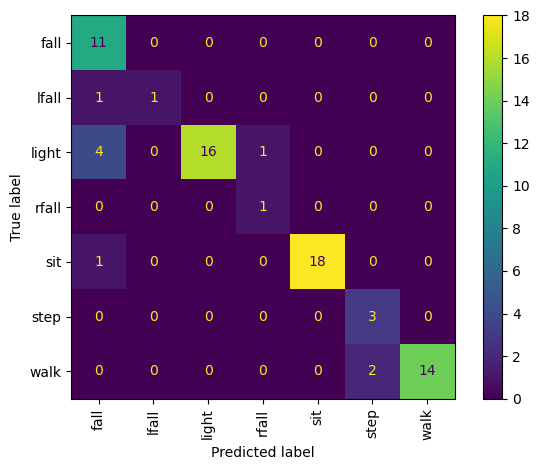

In [34]:
show_results_complete(X_test, y_test, softmax_preds, softmax_clf)

## Resampling

We try to make the data set nicer for our model, since we noticed that a probable issue could be the fact that we have a little number of samples for classes that represent the different types of fall.

In [45]:
X_train_res, X_test_res, y_train_res, y_test_res, y_res = resampling_strategy(df, labels)

As we can see from the comparison we have an unbalanced data set for some classes and this could lead to problems in classification: we do not train the model on enough examples for each label and it is quite difficult to distinguish between classes belonging to the same macro-class (i.e. fall and normal).

We then use a resampling technique called SMOTE, in particular we have selected a variant that performs over and undersampling based on clustering results. In this way we try to ensure a data set that is as balanced as possible.

**KMeans SMOTE** uses a KMeans clustering method before to apply SMOTE. The clustering will group samples together and generate new samples depending of the cluster density.

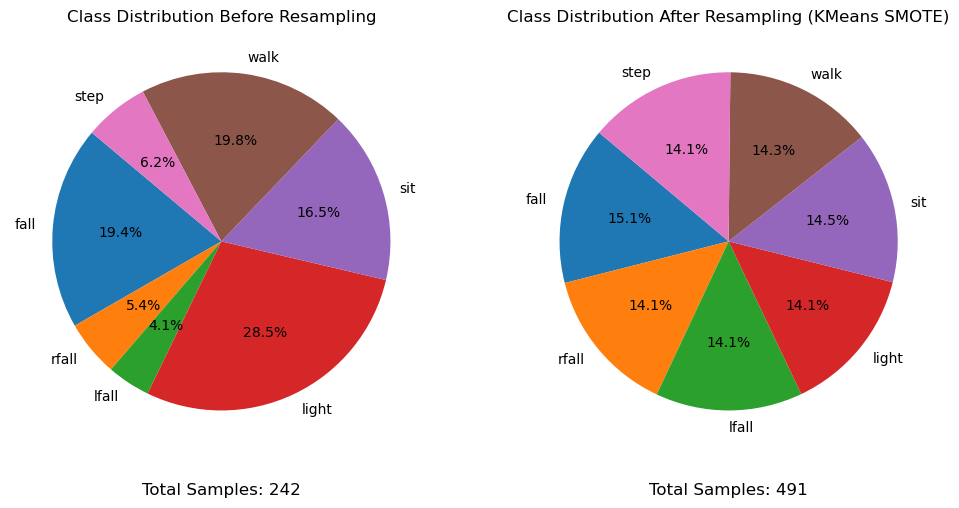

In [46]:
resampling_compare(y, y_res)

In [47]:
softmax_preds_res, softmax_clf_res = best_softmax_fit(X_train_res, X_test_res, y_train_res, y_test_res)

Best parameters: {'warm_start': False, 'solver': 'saga', 'penalty': 'l1', 'max_iter': 350, 'fit_intercept': False, 'class_weight': 'balanced'}
Accuracy:0.8901177675371225
F1-score:0.8737232222946509


              precision    recall  f1-score   support

        fall       0.89      0.67      0.76        24
       lfall       0.78      0.93      0.85        15
       light       0.96      0.74      0.84        31
       rfall       0.73      1.00      0.84        19
         sit       1.00      1.00      1.00        17
        step       0.84      0.89      0.86        18
        walk       0.92      1.00      0.96        24

    accuracy                           0.87       148
   macro avg       0.87      0.89      0.87       148
weighted avg       0.88      0.87      0.87       148



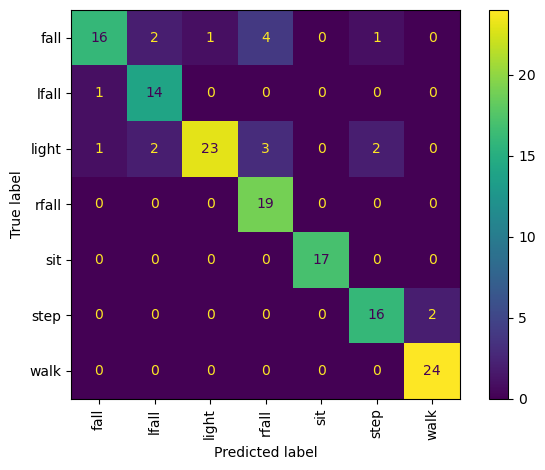

In [48]:
show_results_complete(X_test_res, y_test_res, softmax_preds_res, softmax_clf_res)

## Random Forest

In [51]:
rf_preds, rf_clf = best_rf_fit(X_train_res, X_test_res, y_train_res, y_test_res)

Best parameters: {'n_estimators': 100, 'max_features': 'sqrt', 'max_depth': 100, 'criterion': 'entropy', 'bootstrap': False}
Accuracy:0.8918918918918919
F1-score:0.8812726587420262


The radom forest seems to perform less well than the logistic, and the misclassification error oddly concentrates on the "lfall" and "light" classes differentiating itself from the previously used linear classifier which, always saw the "light" type fall as a problem class, but lost out in the distinction between "fall" and "light."

              precision    recall  f1-score   support

        fall       0.86      0.79      0.83        24
       lfall       0.90      0.60      0.72        15
       light       0.88      0.97      0.92        31
       rfall       0.82      0.95      0.88        19
         sit       0.94      1.00      0.97        17
        step       1.00      0.83      0.91        18
        walk       0.89      1.00      0.94        24

    accuracy                           0.89       148
   macro avg       0.90      0.88      0.88       148
weighted avg       0.90      0.89      0.89       148



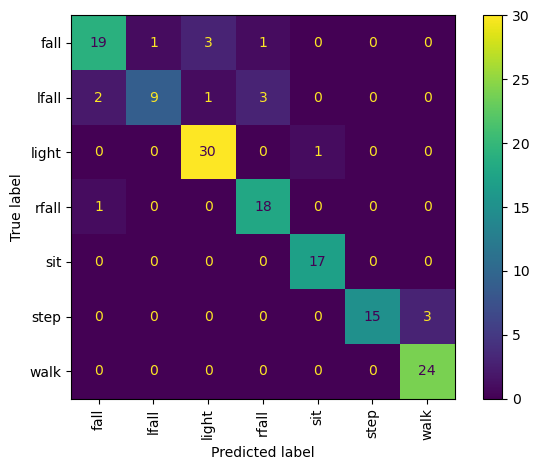

In [52]:
show_results_complete(X_test_res, y_test_res, rf_preds, rf_clf)

## Feature importance with Random Forest

The feature importance describes which features are relevant. It can help with a better understanding of the solved problem and sometimes lead to model improvement by utilizing feature selection. 

Random forest not only represents a good classification model, but also implies the evaluation of fundamental metrics for the evaluation of **feature importance**.

The **mean decrease in Gini coefficient** is a measure of how each variable contributes to the homogeneity of the nodes and leaves in the resulting random forest. The higher the value of mean decrease accuracy or mean decrease Gini score, the higher the importance of the variable in the model.

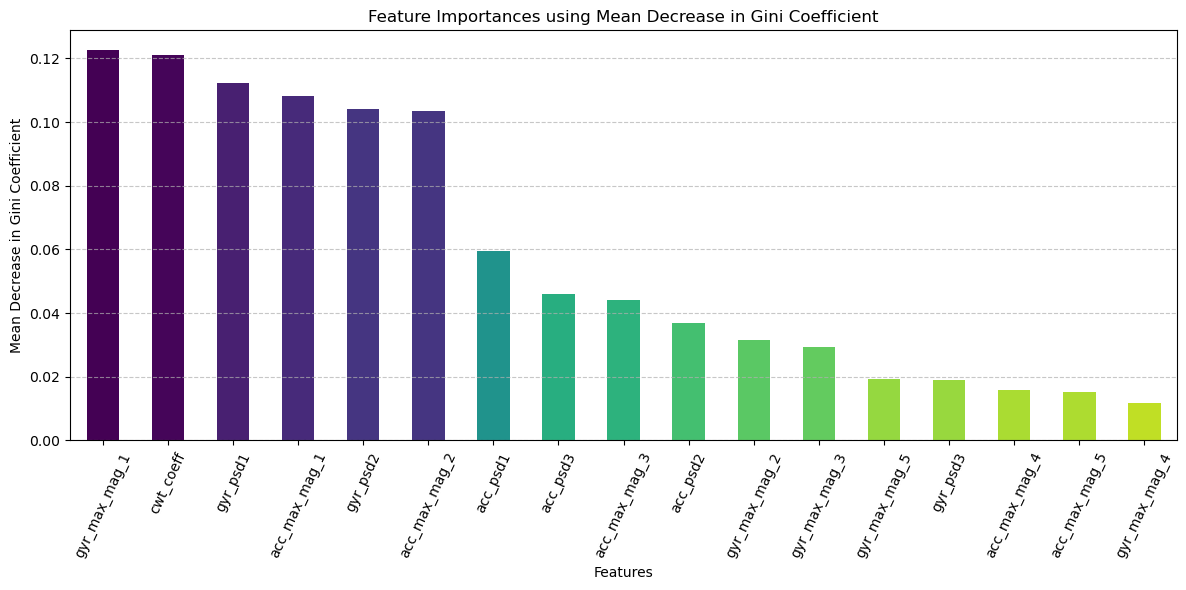

In [ ]:
feature_importances = rf_clf.feature_importances_
forest_importances = pd.Series(feature_importances, index=feature_names)
forest_importances = forest_importances.sort_values(ascending=False)


plt.figure(figsize=(12, 6))  
colors = plt.cm.viridis_r(forest_importances / forest_importances.max())
forest_importances.plot(kind='bar', color=colors)
plt.title("Feature Importances using Mean Decrease in Gini Coefficient")
plt.xlabel("Features")
plt.ylabel("Mean Decrease in Gini Coefficient")
plt.xticks(rotation=65)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

The **Mean Decrease Accuracy** plot expresses how much accuracy the model losses by excluding each variable. The more the accuracy suffers, the more important the variable is for the successful classification. The variables are presented from descending importance.

To evaluate the Feature importance according to the Mean Decrease Accuracy we use the Permutation Importance algorithm implemented in sklearn.

**The Algorithm**:
> __Inputs__: fitted predictive model $m$, tabular dataset (training or validation) $D$;

> Compute the reference score $s$ of the model $m$ on data $D$ (in this case the accuracy of the classifier without a specific feature)

> For each feature $j$ (column of $D$):

>- For each repetition k in 1,...,$K$:
    >>* randomly shuffle column $j$ to generate a corrupted version of the data named $\hat{D}_{k,j}$
    >>* compute the score $s_{k,j}$ of model $m$ on corrupted data $\hat{D}_{k,j}$

>- Compute the importance $i_j$ for feature $f_j$ defined as: $$i_j = s - \frac{1}{K} \sum_{k=1}^{K} s_{k,j}$$



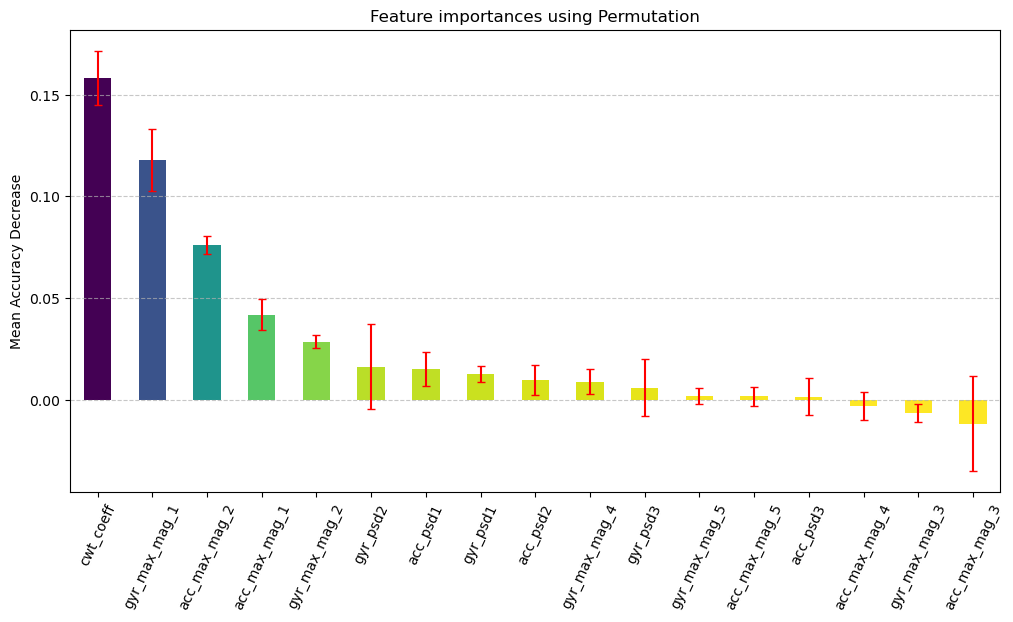

In [110]:
result = permutation_importance(
    rf_clf, X_test_res, y_test_res, n_repeats=40, random_state=42, n_jobs=-1
)
feature_names = df.columns

forest_importances = pd.Series(result.importances_mean, index=feature_names)
forest_importances = forest_importances.sort_values(ascending=False)

plt.figure(figsize=(12, 6))
colors = plt.cm.viridis_r(forest_importances / forest_importances.max())
plt.errorbar(forest_importances.index, forest_importances, yerr=result.importances_std, 
             fmt='none', ecolor='red', capsize=3)
forest_importances.plot(kind='bar', color=colors)
plt.title("Feature importances using Permutation")
plt.ylabel("Mean Accuracy Decrease")
plt.xticks(rotation=65)
plt.grid(axis='y', linestyle='--', alpha=0.7)
fig.tight_layout()
plt.show()

Before plotting these results regarding the importance of the features we believed it might be very informative to introduce more power spectrum peaks at low frequencies. Apparently, however, we had to change our minds by identifying other attributes as critical factors for classification.

## Multicollinearity check

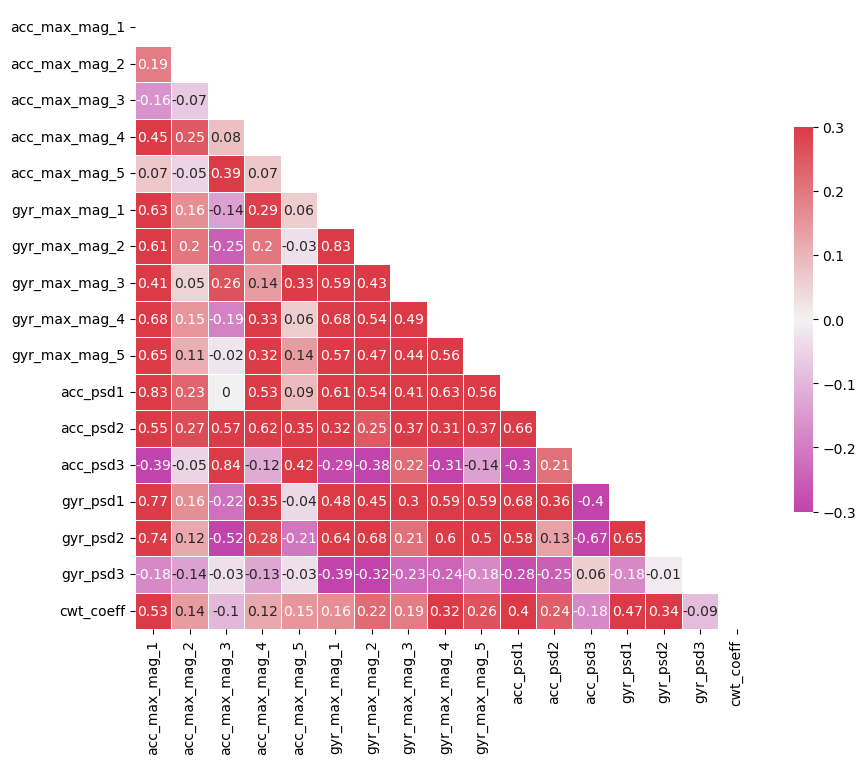

In [77]:
plt.figure(figsize=(10, 10))  
corr=round(df.corr(),2)

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(680, 10, as_cmap=True)

sns.heatmap(corr, mask=mask,cmap=cmap, annot=True,vmax=.3,vmin=-.3,center=0,
            square=True,linewidths=.5, cbar_kws={"shrink": .5}  
)
plt.show()

In [111]:
vif_data = pd.DataFrame()
vif_data["feature"] = df.columns
  
vif_data["VIF"] = [variance_inflation_factor(df.values, i)
                          for i in range(len(df.columns))]
  
vif_data_sort=vif_data.sort_values(by=['VIF'], ascending=False)

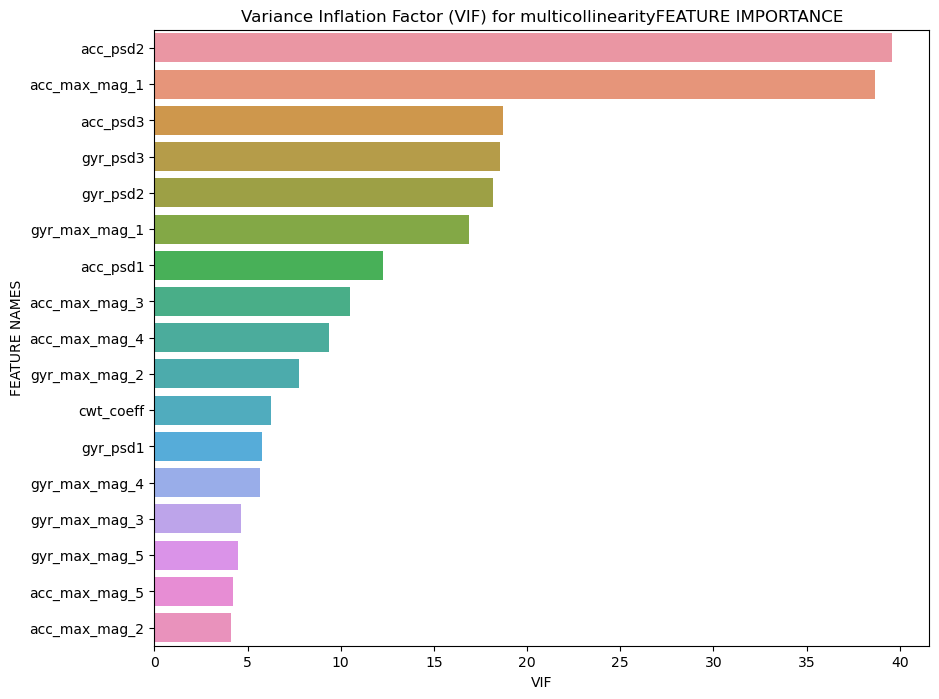

In [112]:
plot_feature_importance(vif_data_sort['VIF'],vif_data_sort['feature'],'Variance Inflation Factor (VIF) for multicollinearity')

## Random forest with only important features

We tried to use less but "more important" features but the results seems to not really improve...

Best parameters: {'n_estimators': 500, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'log_loss', 'bootstrap': True}
Accuracy:0.8986486486486487
F1-score:0.901968778590205
              precision    recall  f1-score   support

        fall       0.94      0.67      0.78        24
       lfall       1.00      0.87      0.93        15
       light       0.88      0.94      0.91        31
       rfall       0.79      1.00      0.88        19
         sit       1.00      1.00      1.00        17
        step       1.00      0.83      0.91        18
        walk       0.83      1.00      0.91        24

    accuracy                           0.90       148
   macro avg       0.92      0.90      0.90       148
weighted avg       0.91      0.90      0.90       148



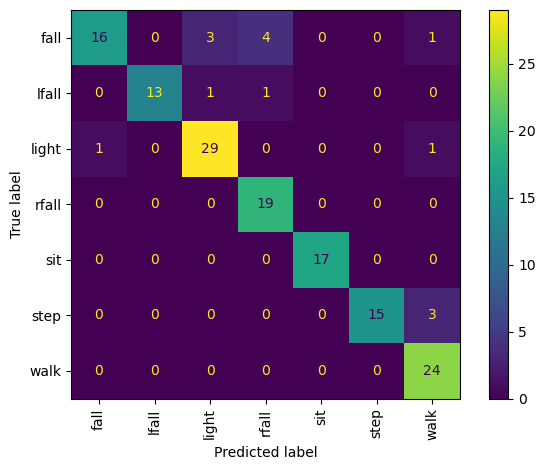

Total pipeline computation time:0.33 seconds.


In [56]:
# select the best features
df_fi = df[["acc_max_mag_1", "gyr_max_mag_1","acc_max_mag_2", "gyr_max_mag_2", "cwt_coeff", "acc_psd1", "gyr_psd1"]]

start = time.time()
X_train_res_fi, X_test_res_fi, y_train_res_fi, y_test_res_fi, _ = resampling_strategy(df_fi, labels)
end = time.time()

rf_preds_fi, rf_clf_fi = best_rf_fit(X_train_res_fi, X_test_res_fi, y_train_res_fi, y_test_res_fi)
show_results_complete(X_test_res_fi, y_test_res_fi, rf_preds_fi, rf_clf_fi)

print(f'Total pipeline computation time:{round(end-start,2)} seconds.')


## Collapsing uninformative classes

In [59]:
# Mapping for relabeling
label_mapping = {
    'fall' :'fall',
    'rfall': 'rfall',
    'lfall': 'lfall',
    'light': 'fall', # only collapse "light" and "fall" classes
    'sit': 'sit',
    'walk': 'walk',
    'step': 'step'
}

# Replace existing labels with new labels
df_new['label'] = labels
df_new['label'] = df_new['label'].map(label_mapping)

y_new = df_new["label"]
df_new = df_new.drop("label", axis=1)

In [61]:
X_train_res, X_test_res, y_train_res, y_test_res, _ = resampling_strategy(df_new, y_new)

In [62]:
softmax_preds, softmax_clf = best_softmax_fit(X_train_res, X_test_res, y_train_res, y_test_res)

Best parameters: {'warm_start': False, 'solver': 'lbfgs', 'penalty': None, 'max_iter': 50, 'fit_intercept': True, 'class_weight': 'balanced'}
Accuracy:0.9311619311619311
F1-score:0.9219374158011832


It seems that, using the same algorithm and the same resampling technique to balance classes, the overall performances improve of the ~4% both in terms of accuracy and f1 score simply collapsing the two most similar classes

              precision    recall  f1-score   support

        fall       0.96      0.64      0.77        39
       lfall       0.80      0.95      0.86        37
       rfall       0.84      1.00      0.91        26
         sit       1.00      1.00      1.00        35
        step       1.00      1.00      1.00        38
        walk       0.97      1.00      0.99        35

    accuracy                           0.92       210
   macro avg       0.93      0.93      0.92       210
weighted avg       0.93      0.92      0.92       210



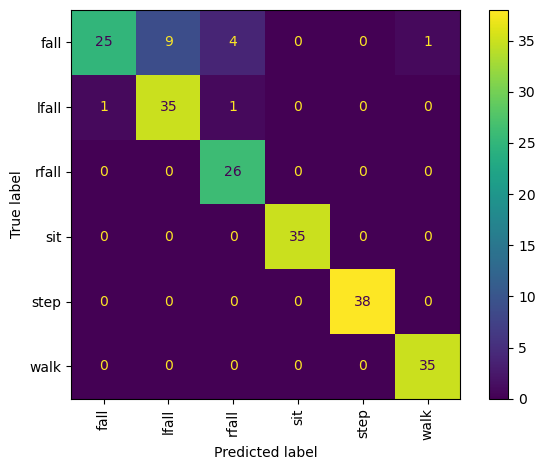

In [64]:
show_results_complete(X_test_res, y_test_res, softmax_preds, softmax_clf)

## Final model selection

Best parameters: {'n_estimators': 200, 'max_features': 'log2', 'max_depth': None, 'criterion': 'log_loss', 'bootstrap': True}
Accuracy:0.9809523809523809
F1-score:0.9811586968819673
              precision    recall  f1-score   support

        fall       0.93      1.00      0.96        39
       lfall       1.00      0.89      0.94        37
       rfall       0.96      1.00      0.98        26
         sit       1.00      1.00      1.00        35
        step       1.00      1.00      1.00        38
        walk       1.00      1.00      1.00        35

    accuracy                           0.98       210
   macro avg       0.98      0.98      0.98       210
weighted avg       0.98      0.98      0.98       210



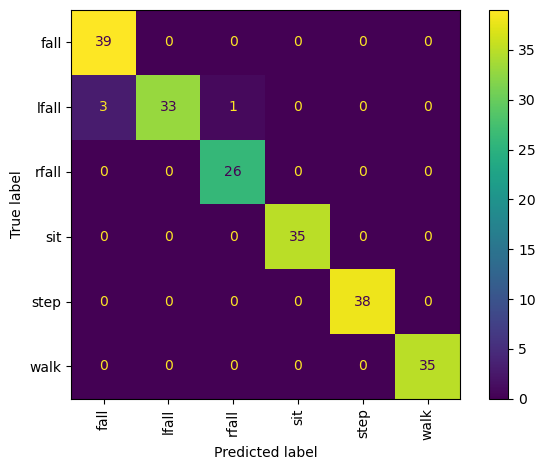

In [65]:
rf_preds, rf_clf = best_rf_fit(X_train_res, X_test_res, y_train_res, y_test_res)
show_results_complete(X_test_res, y_test_res, rf_preds, rf_clf)

Best parameters: {'shrinking': True, 'kernel': 'rbf', 'degree': 8, 'decision_function_shape': 'ovr', 'break_ties': True, 'C': 2}
Accuracy:0.9809523809523809
F1-score:0.9804557930486498
              precision    recall  f1-score   support

        fall       0.95      0.97      0.96        39
       lfall       1.00      0.92      0.96        37
       rfall       0.93      1.00      0.96        26
         sit       1.00      1.00      1.00        35
        step       1.00      1.00      1.00        38
        walk       1.00      1.00      1.00        35

    accuracy                           0.98       210
   macro avg       0.98      0.98      0.98       210
weighted avg       0.98      0.98      0.98       210



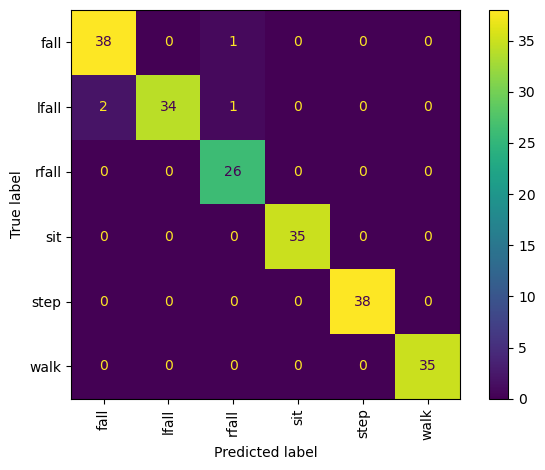

In [68]:
svm_preds, svm_clf = best_svm_fit(X_train_res, X_test_res, y_train_res, y_test_res)
show_results_complete(X_test_res, y_test_res, svm_preds, svm_clf)

In [77]:
le = LabelEncoder()
le.fit(y_train_res.unique())
y_tr = le.transform(y_train_res)
y_te = le.transform(y_test_res)

xgb_preds, xgb_clf = best_svm_fit(X_train_res, X_test_res, y_tr, y_te)
#show_results_complete(X_test_res, y_te, xgb_preds, xgb_clf)

Best parameters: {'shrinking': True, 'kernel': 'rbf', 'degree': 4, 'decision_function_shape': 'ovo', 'break_ties': False, 'C': 2}
Accuracy:0.9809523809523809
F1-score:0.9804557930486498


Best parameters: {'p': 2, 'n_neighbors': 5, 'leaf_size': 150, 'algorithm': 'ball_tree'}
Accuracy:0.9238095238095239
F1-score:0.9223360914733164
              precision    recall  f1-score   support

        fall       0.97      0.74      0.84        39
       lfall       0.87      0.92      0.89        37
       rfall       0.79      1.00      0.88        26
         sit       0.97      1.00      0.99        35
        step       0.97      0.95      0.96        38
        walk       0.97      0.97      0.97        35

    accuracy                           0.92       210
   macro avg       0.92      0.93      0.92       210
weighted avg       0.93      0.92      0.92       210



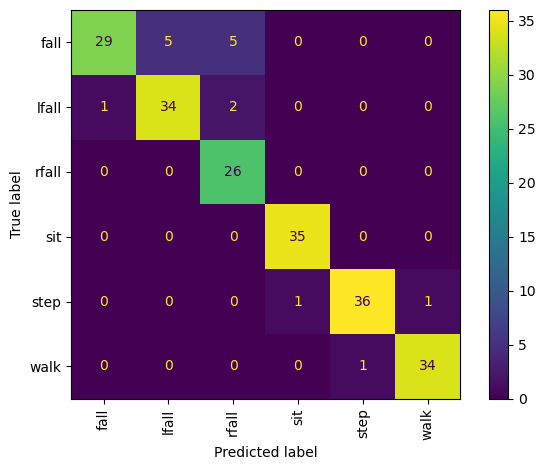

In [84]:
# KNN
knn_preds, knn_clf = best_knn_fit(X_train_res, X_test_res, y_train_res, y_test_res)
show_results_complete(X_test_res, y_test_res, knn_preds, knn_clf)

Best parameters: {'n_estimators': 140, 'learning_rate': 1.0, 'algorithm': 'SAMME.R'}
Accuracy:0.9285714285714286
F1-score:0.9278056152899051
              precision    recall  f1-score   support

        fall       0.78      1.00      0.88        39
       lfall       1.00      0.65      0.79        37
       rfall       0.90      1.00      0.95        26
         sit       1.00      0.97      0.99        35
        step       1.00      0.97      0.99        38
        walk       0.97      1.00      0.99        35

    accuracy                           0.93       210
   macro avg       0.94      0.93      0.93       210
weighted avg       0.94      0.93      0.93       210



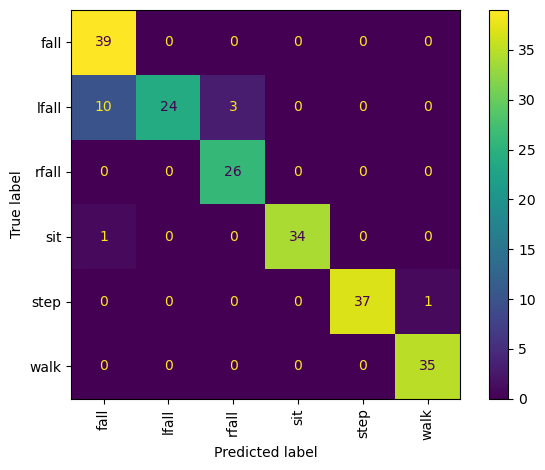

In [82]:
# ADA BOOST
ada_preds, ada_clf = best_ada_fit(X_train_res, X_test_res, y_train_res, y_test_res)
show_results_complete(X_test_res, y_test_res, ada_preds, ada_clf)

Best parameters: {'warm_start': True, 'shuffle': False, 'penalty': 'elasticnet', 'n_iter_no_change': 45, 'max_iter': 3600, 'fit_intercept': True, 'early_stopping': False, 'alpha': 0.0001}
Accuracy:0.9333333333333333
F1-score:0.9352263366127856
              precision    recall  f1-score   support

        fall       0.94      0.82      0.88        39
       lfall       0.90      0.95      0.92        37
       rfall       0.93      1.00      0.96        26
         sit       1.00      1.00      1.00        35
        step       1.00      0.87      0.93        38
        walk       0.85      1.00      0.92        35

    accuracy                           0.93       210
   macro avg       0.94      0.94      0.94       210
weighted avg       0.94      0.93      0.93       210



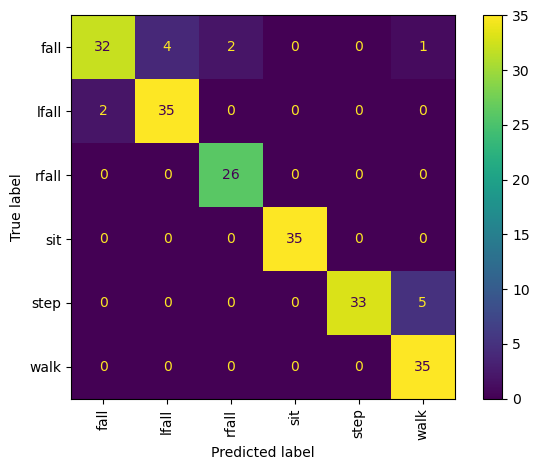

In [86]:
# PERCEPTRON
perc_preds, perc_clf = best_perc_fit(X_train_res, X_test_res, y_train_res, y_test_res)
show_results_complete(X_test_res, y_test_res, perc_preds, perc_clf)

### ROC curves